# Bengali.AI SEResNeXt training with pytorch

I will introduce following contents

 - **Fast data loading** with feather format
 - **Data augmentation** technic with affine transformation
 - **CNN SoTA models**: Use pytorch `pretrainedmodels` library, especially I use **`SEResNeXt`** in this notebook
 - **Training code abstraction**: Use `pytorch-ignite` module for the trainining abstraction
 
### Update history

 - 2020/1/4 v2: Added albumentations augmentations introduced in [Bengali: albumentations data augmentation tutorial](https://www.kaggle.com/corochann/bengali-albumentations-data-augmentation-tutorial)

# Table of Contents:
**[Fast data loading with feather](#load)**<br>
**[Dataset](#dataset)**<br>
**[Data augmentation/processing](#processing)**<br>
**[pytorch model & define classifier](#model)**<br>
**[Training code](#train)**<br>
**[Prediction](#pred)**<br>
**[Reference and further reading](#ref)**<br>

To install https://github.com/Cadene/pretrained-models.pytorch without internet connection, we can install library as "dataset".

It is uploaded by @rishabhiitbhu : https://www.kaggle.com/rishabhiitbhu/pretrainedmodels

In [1]:
!pip install pretrainedmodels

In [2]:
import gc
import os
from pathlib import Path
import random
import sys

from tqdm.notebook import tqdm
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns

from IPython.core.display import display, HTML

# --- plotly ---
from plotly import tools, subplots
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff

# --- models ---
from sklearn import preprocessing
from sklearn.model_selection import KFold
import lightgbm as lgb
import xgboost as xgb
import catboost as cb

# --- setup ---
pd.set_option('max_columns', 50)

# PATH = "/Users/helen/Desktop/Data/bengaliai-cv19/"
# FEATHER_PATH = "/Users/helen/Desktop/Data/bengaliaicv19feather/"

PATH = "/home/chen/Work/ly/data/Bengaliai/bengaliai-cv19/"
FEATHER_PATH = "/home/chen/Work/ly/data/Bengaliai/bengaliaicv19feather/"

# PATH = "/home/vemlr/Work/chen_huang/Data/bengaliai-cv19/"
# FEATHER_PATH = "/home/vemlr/Work/chen_huang/Data/bengaliaicv19feather/"

In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk(PATH):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/home/chen/Work/ly/data/Bengaliai/bengaliai-cv19/train.csv
/home/chen/Work/ly/data/Bengaliai/bengaliai-cv19/train_image_data_1.parquet
/home/chen/Work/ly/data/Bengaliai/bengaliai-cv19/train_image_data_0.parquet
/home/chen/Work/ly/data/Bengaliai/bengaliai-cv19/test.csv
/home/chen/Work/ly/data/Bengaliai/bengaliai-cv19/train_image_data_2.parquet
/home/chen/Work/ly/data/Bengaliai/bengaliai-cv19/test_image_data_3.parquet
/home/chen/Work/ly/data/Bengaliai/bengaliai-cv19/test_image_data_2.parquet
/home/chen/Work/ly/data/Bengaliai/bengaliai-cv19/test_image_data_1.parquet
/home/chen/Work/ly/data/Bengaliai/bengaliai-cv19/test_image_data_0.parquet
/home/chen/Work/ly/data/Bengaliai/bengaliai-cv19/sample_submission.csv
/home/chen/Work/ly/data/Bengaliai/bengaliai-cv19/class_map.csv
/home/chen/Work/ly/data/Bengaliai/bengaliai-cv19/train_image_data_3.parquet


In [4]:
import torch

debug = False
submission=False
batch_size= 48
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
out='.'
image_size= 128
arch='pretrained'
model_name='ResNext50'

HEIGHT = 137
WIDTH = 236
# FACTOR = 0.25
HEIGHT_NEW = 112
WIDTH_NEW = 112
# HEIGHT_NEW = int(HEIGHT*FACTOR)
# WIDTH_NEW = int(WIDTH*FACTOR)
print(WIDTH_NEW, HEIGHT_NEW)

112 112


In [5]:
datadir = Path(PATH)
featherdir = Path(FEATHER_PATH)
LR = 5e-5
WD = 1e-4
DP = 0.2
HDIM = 1024
outdir = Path('../res/{}_LR{}_WD{}_DP{}_IM{}-{}_bs{}_4head_c3aug-ftall'.format(model_name, LR, WD, DP, HEIGHT_NEW, WIDTH_NEW,
                                                            batch_size))

trained_model_name = "/home/chen/Work/ly/DL/Bengali_competition/res/best/predictor_2.pt"

TH = 20.0

In [6]:
# Read in the data CSV files
# train = pd.read_csv(datadir/'train.csv')
# test = pd.read_csv(datadir/'test.csv')
# sample_submission = pd.read_csv(datadir/'sample_submission.csv')
# class_map = pd.read_csv(datadir/'class_map.csv')

# Fast data loading with feather

Refer [Bengali.AI super fast data loading with feather](https://www.kaggle.com/corochann/bengali-ai-super-fast-data-loading-with-feather) and [dataset](https://www.kaggle.com/corochann/bengaliaicv19feather) for detail.<br/>
Original `parquet` format takes about 60 sec to load 1 data, while `feather` format takes about **2 sec to load 1 data!!!**

### How to add dataset

When you write kernel, click "+ Add Data" botton on right top.<br/>
Then inside window pop-up, you can see "Search Datasets" text box on right top.<br/>
You can type "bengaliai-cv19-feather" to find this dataset and press "Add" botton to add the data.

In [7]:
import cv2
def bbox(img):
    rows = np.any(img, axis=1)
    cols = np.any(img, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]
    return rmin, rmax, cmin, cmax

def crop_resize(img0, size=image_size, pad=3, thh = 80, thl = 28):
    #crop a box around pixels large than the threshold 
    #some images contain line at the sides
    ymin,ymax,xmin,xmax = bbox(img0[5:-5,5:-5] > thh)
    #cropping may cut too much, so we need to add it back
    xmin = xmin - 13 if (xmin > 13) else 0
    ymin = ymin - 10 if (ymin > 10) else 0
    xmax = xmax + 13 if (xmax < WIDTH - 13) else WIDTH
    ymax = ymax + 10 if (ymax < HEIGHT - 10) else HEIGHT
    img = img0[ymin:ymax,xmin:xmax]
    #remove lo intensity pixels as noise
    img[img < thl] = 0
    lx, ly = xmax-xmin,ymax-ymin
    l = max(lx,ly) + pad
    #make sure that the aspect ratio is kept in rescaling
    img = np.pad(img, [((l-ly)//2,), ((l-lx)//2,)], mode='constant')
    return cv2.resize(img,(size,size))


In [8]:
import numpy as np
import pandas as pd
import gc


def prepare_image(datadir, featherdir, data_type='train',
                  submission=False, indices=[0, 1, 2, 3]):
    assert data_type in ['train', 'test']
    if submission:
        image_df_list = [pd.read_parquet(datadir / f'{data_type}_image_data_{i}.parquet')
                         for i in indices]
    else:
        image_df_list = [pd.read_feather(featherdir / f'{data_type}_image_data_{i}.feather')
                         for i in indices]

    print('image_df_list', len(image_df_list))
    images = [df.iloc[:, 1:].values.reshape(-1, HEIGHT, WIDTH).astype('uint8') for df in image_df_list]

#     images = []
#     for df in image_df_list:
#         for idx in tqdm(range(len(df))):
#             images.append(crop_resize(df.iloc[idx, 1:].values.reshape(HEIGHT, WIDTH).astype('uint8')))
    del image_df_list
    gc.collect()
    images = np.concatenate(images, axis=0)
    return images


In [9]:
# train = pd.read_csv(datadir/'train.csv')
train = pd.read_csv('train_with_fold-comb.csv')
train_labels = train[['grapheme_root', 'vowel_diacritic', 'consonant_diacritic', 'comb_label']].values
n_comb_class = 1295
# class_map = dict(pd.read_csv('grapheme_1295.csv')[['grapheme','label']].values)
# comb_labels = np.array([class_map[itm] for ind, itm in train['grapheme'].items()]).reshape(-1,1)
# train_labels4 = np.hstack((train_labels, comb_labels))
# train['comb_label'] = comb_labels
# train.to_csv('train_with_fold-comb.csv')

In [10]:
a = np.random.rand(3,1)
print(np.shape(a))
# b = np.random.rand(3,4)
# print(a,b)
# c = np.hstack((a,b))
# print(c)
d = np.array([1,1])
print(np.shape(d))
d = d.reshape(-1,1)
print(np.shape(d))

(3, 1)
(2,)
(2, 1)


In [11]:
# print(class_map)

In [12]:
%%time
indices = [0,1,2,3] #if debug else [0, 1, 2, 3]
train_images = prepare_image(
    datadir, featherdir, data_type='train', submission=False, indices=indices)

image_df_list 4
CPU times: user 30.9 s, sys: 31.9 s, total: 1min 2s
Wall time: 7.18 s


In [13]:
print(len(train_labels))
print(len(train))
print(train_labels[200840-1])

200840
200840
[127   2   0  58]


In [14]:
#  import sys 

# # These are the usual ipython objects, including this one you are creating 
# ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars'] 

# # Get a sorted list of the objects and their sizes 
# sorted([(x, sys.getsizeof(globals().get(x))) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True) 

<a id="dataset"></a>
# Dataset

In [15]:
"""
Referenced `chainer.dataset.DatasetMixin` to work with pytorch Dataset.
"""
import numpy
import six
import torch
from torch.utils.data.dataset import Dataset


class DatasetMixin(Dataset):

    def __init__(self, transform=None):
        self.transform = transform

    def __getitem__(self, index):
        """Returns an example or a sequence of examples."""
        if torch.is_tensor(index):
            index = index.tolist()
        if isinstance(index, slice):
            current, stop, step = index.indices(len(self))
            return [self.get_example_wrapper(i) for i in
                    six.moves.range(current, stop, step)]
        elif isinstance(index, list) or isinstance(index, numpy.ndarray):
            return [self.get_example_wrapper(i) for i in index]
        else:
            return self.get_example_wrapper(index)

    def __len__(self):
        """Returns the number of data points."""
        raise NotImplementedError

    def get_example_wrapper(self, i):
        """Wrapper of `get_example`, to apply `transform` if necessary"""
        example = self.get_example(i)
        if self.transform:
            example = self.transform(example)
        return example

    def get_example(self, i):
        """Returns the i-th example.

        Implementations should override it. It should raise :class:`IndexError`
        if the index is invalid.

        Args:
            i (int): The index of the example.

        Returns:
            The i-th example.

        """
        raise NotImplementedError


This `DatasetMixin` class can be used to define any custom dataset class in pytorch. We can implement `get_example(self, i)` method to return `i`-th data.

Here I return i-th image `x` and `label`, with scaling image to be value ranges between 0~1.

In [16]:
import numpy as np


class BengaliAIDataset(DatasetMixin):
    def __init__(self, images, labels=None, transform=None, indices=None):
        super(BengaliAIDataset, self).__init__(transform=transform)
        self.images = images
        self.labels = labels
        if indices is None:
            indices = np.arange(len(images))
        self.indices = indices
        self.train = labels is not None

    def __len__(self):
        """return length of this dataset"""
        return len(self.indices)

    def get_example(self, i):
        """Return i-th data"""
        i = self.indices[i]
        x = self.images[i]
        # Opposite white and black: background will be white and
        # for future Affine transformation
        x = (255 - x).astype(np.float32) / 255.
        if self.train:
            y = self.labels[i]
            return x, y
        else:
            return x


Let's see how this `BengaliAIDataset` work

In [17]:
# train_dataset_noaug = BengaliAIDataset(train_images[:200], train_labels)

`train_dataset[i]` returns i-th image array and 3 target labels (graphme_root, vowel_diacritic and consonant_diacritic).

In [18]:
# image, label = train_dataset_noaug[0]
# print('image', image.shape, 'label', label)

In [19]:
# print(image[:5,:5])
# print(20/255)

In [20]:
# nrow, ncol = 5, 6

# fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
# axes = axes.flatten()
# for i, ax in tqdm(enumerate(axes)):
#     image, label = train_dataset_noaug[i]
#     ax.imshow(crop_resize(image, thh = TH/255, thl=28.0/255)) #, cmap='Greys'
#     ax.set_title(f'label: {label}')
# plt.tight_layout()
# plt.show()
# plt.savefig('bengaliai.png')

<a id="processing"></a>
# Data augmentation/processing

For CNN training, data augmentation is important to improve test accuracy (generalization performance). I will show some image preprocessing to increase the data variety.

In [21]:
"""
From https://www.kaggle.com/corochann/deep-learning-cnn-with-chainer-lb-0-99700
"""
import cv2
from skimage.transform import SimilarityTransform, AffineTransform, warp
import numpy as np
import math


def affine_image(img):
    """

    Args:
        img: (h, w) or (1, h, w)

    Returns:
        img: (h, w)
    """
    # ch, h, w = img.shape
    # img = img / 255.
    if img.ndim == 3:
        img = img[0]

    # --- scale ---
    min_scale = 0.85
    max_scale = 1.15
    sx = np.random.uniform(min_scale, max_scale)
    sy = np.random.uniform(min_scale, max_scale)

    # --- rotation ---
    max_rot_angle = 10
    rot_angle = np.random.uniform(-max_rot_angle, max_rot_angle)*np.pi/180.0

    # --- shear ---
    max_shear_angle = 10
    shear_angle = np.random.uniform(-max_shear_angle, max_shear_angle)*np.pi/180.0

    # --- translation ---
    max_translation = image_size*0.075
    tx = np.random.randint(-max_translation, max_translation)
    ty = np.random.randint(-max_translation, max_translation)
    
#     print("rot:{}, shear:{},tx:{},ty:{}".format(rot_angle,shear_angle, tx,ty))
    
    shape = img.shape
    shape_size = shape[:2]
    center = np.float32(shape_size) / 2.
        
    pre = SimilarityTransform(translation=-center)
    tform = AffineTransform(scale=(sx, sy), rotation=rot_angle, shear=shear_angle, translation=(tx,ty)) 
    after = AffineTransform(translation=center)
    total_transform = pre+tform+after
#     total_transform = tform
    transformed_image = warp(img, total_transform.params, mode='constant')
    
    assert transformed_image.ndim == 2
    return transformed_image

def bbox(img):
    rows = np.any(img, axis=1)
    cols = np.any(img, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]
    return rmin, rmax, cmin, cmax

def crop_char_image_thin(image, threshold=40./255., pad = 16):
    assert image.ndim == 2
    is_black = image > threshold

    is_black_vertical = np.sum(is_black, axis=0) > 0
    is_black_horizontal = np.sum(is_black, axis=1) > 0
    left = np.argmax(is_black_horizontal)
    right = np.argmax(is_black_horizontal[::-1])
    top = np.argmax(is_black_vertical)
    bottom = np.argmax(is_black_vertical[::-1])
    height, width = image.shape
    cropped_image = image[left:height - right, top:width - bottom]
    return cropped_image

def crop_char_image(img0, threshold=TH/255., pad=10):
    ymin,ymax,xmin,xmax = bbox(img0[5:-5,5:-5] > threshold)
    #cropping may cut too much, so we need to add it back
#     xmin = xmin - 5 if (xmin > 5) else 0
#     ymin = ymin - 5 if (ymin > 5) else 0
#     xmax = xmax + 5 if (xmax < WIDTH - 5) else WIDTH
#     ymax = ymax + 5 if (ymax < HEIGHT - 5) else HEIGHT
    xmin = xmin - 13 if (xmin > 13) else 0
    ymin = ymin - 10 if (ymin > 10) else 0
    xmax = xmax + 13 if (xmax < WIDTH - 13) else WIDTH
    ymax = ymax + 10 if (ymax < HEIGHT - 10) else HEIGHT
    img = img0[ymin:ymax,xmin:xmax]
    #remove lo intensity pixels as noise
    img[img < 28./255.] = 0
    lx, ly = xmax-xmin,ymax-ymin
    l = max(lx,ly) + pad
    #make sure that the aspect ratio is kept in rescaling
    img = np.pad(img, [((l-ly)//2,), ((l-lx)//2,)], mode='constant')
    return img

# def crop_char_image_new(img0, threshold=TH/255., pad=10):
#     ymin,ymax,xmin,xmax = bbox(img0 > threshold)
#     #cropping may cut too much, so we need to add it back
# #     xmin = xmin - 13 if (xmin > 13) else 0
# #     ymin = ymin - 10 if (ymin > 10) else 0
# #     xmax = xmax + 13 if (xmax < WIDTH - 13) else WIDTH
# #     ymax = ymax + 10 if (ymax < HEIGHT - 10) else HEIGHT
#     img = img0[ymin:ymax,xmin:xmax]
#     #remove lo intensity pixels as noise
#     img[img < 28./255.] = 0
#     lx, ly = xmax-xmin,ymax-ymin
#     l = max(lx,ly) + pad
#     #make sure that the aspect ratio is kept in rescaling
#     img = np.pad(img, [(pad//2,), (pad//2,)], mode='constant')
#     return img

def resize(image, size=(WIDTH_NEW, HEIGHT_NEW)):
    return cv2.resize(image, size)

## Affine transformation for data augmentation

To increase validation score, the number of training data is important. When we can use more number of training data, we can reduce overfitting and validation score becomes high.

"Data augmentation" is a technic to virtually create extra training data, based on the given training data. For this MNIST task, data augmentation can be achieved by utilizing affine transformation.

1. Rotation AffineTransformation
2. Translation
3. Scale
4. Shear

In [22]:
# nrow, ncol = 3, 6

# fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
# axes = axes.flatten()
# for i, ax in tqdm(enumerate(axes)):
#     image, label = train_dataset_noaug[2]
#     if i ==0:
#         ax.imshow(image, cmap='Greys')
#     else:
#         ax.imshow(resize(crop_char_image_thin(affine_image(crop_char_image(image)))), cmap='Greys')
#     ax.set_title(f'label: {label}')
# plt.tight_layout()
# # crop_resize(image, thh = 80.0/255, thl=28.0/255, pad=16)

In [23]:
# nrow, ncol = 3, 6

# fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
# axes = axes.flatten()
# PAD = 20
# for i, ax in tqdm(enumerate(axes)):
#     image, label = train_dataset_noaug[2]
#     if i ==0:
#         ax.imshow(image, cmap='Greys')
#     elif i==1:
#         ax.imshow(crop_char_image(image), cmap='Greys')
#     else:
#         ax.imshow(resize((affine_image(crop_char_image(image)))), cmap='Greys')
#     ax.set_title(f'label: {label}')
# plt.tight_layout()

When the image is slightly rotated, shifted (transformed) or scaled, the image looks like the same label. We can virtually create another image data from one image in such a way.

## crop image

Here I crop image

In [24]:
# nrow, ncol = 5, 6

# fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
# axes = axes.flatten()
# for i, ax in tqdm(enumerate(axes)):
#     image, label = train_dataset_noaug[i]
#     ax.imshow(crop_char_image(image, threshold=TH/255.), cmap='Greys')
#     ax.set_title(f'label: {label}')
# plt.tight_layout()

## resize image

We need to resize image after crop, to align image size for CNN batch training.

whole process: crop_Char_imgage->affine->crop_char_image_thin->resize

In [25]:
# nrow, ncol = 5, 6

# fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
# axes = axes.flatten()
# for i, ax in tqdm(enumerate(axes)):
#     image, label = train_dataset_noaug[i]
#     ax.imshow(resize((affine_image((crop_char_image(image, threshold=TH/255.))))), cmap='Greys')
#     ax.set_title(f'label: {label}')
# plt.tight_layout()

Put everything together with `Transform` class. <br>
[Update] I added **albumentations augmentations** introduced in [Bengali: albumentations data augmentation tutorial](https://www.kaggle.com/corochann/bengali-albumentations-data-augmentation-tutorial).

In [26]:
from albumentations import (
    HorizontalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine,IAAAffine,
    IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose
)

In [27]:
affine_train_transform = Compose([
    OneOf([
        ShiftScaleRotate(scale_limit=.15, rotate_limit=20, border_mode=cv2.BORDER_CONSTANT),
        IAAAffine(shear=20, mode='constant'),
        IAAPerspective(),
    ])
])

In [28]:
import albumentations
from albumentations.core.transforms_interface import DualTransform
from albumentations.augmentations import functional as AF

In [29]:
class GridMask(DualTransform):
    """GridMask augmentation for image classification and object detection.
    
    Author: Qishen Ha
    Email: haqishen@gmail.com
    2020/01/29

    Args:
        num_grid (int): number of grid in a row or column.
        fill_value (int, float, lisf of int, list of float): value for dropped pixels.
        rotate ((int, int) or int): range from which a random angle is picked. If rotate is a single int
            an angle is picked from (-rotate, rotate). Default: (-90, 90)
        mode (int):
            0 - cropout a quarter of the square of each grid (left top)
            1 - reserve a quarter of the square of each grid (left top)
            2 - cropout 2 quarter of the square of each grid (left top & right bottom)

    Targets:
        image, mask

    Image types:
        uint8, float32

    Reference:
    |  https://arxiv.org/abs/2001.04086
    |  https://github.com/akuxcw/GridMask
    """

    def __init__(self, num_grid=3, fill_value=0, rotate=90, mode=0, always_apply=False, p=0.5):
        super(GridMask, self).__init__(always_apply, p)
        if isinstance(num_grid, int):
            num_grid = (num_grid, num_grid)
        if isinstance(rotate, int):
            rotate = (-rotate, rotate)
        self.num_grid = num_grid
        self.fill_value = fill_value
        self.rotate = rotate
        self.mode = mode
        self.masks = None
        self.rand_h_max = []
        self.rand_w_max = []

    def init_masks(self, height, width):
        if self.masks is None:
            self.masks = []
            n_masks = self.num_grid[1] - self.num_grid[0] + 1
            for n, n_g in enumerate(range(self.num_grid[0], self.num_grid[1] + 1, 1)):
                grid_h = height / n_g
                grid_w = width / n_g
                this_mask = np.ones((int((n_g + 1) * grid_h), int((n_g + 1) * grid_w))).astype(np.uint8)
                for i in range(n_g + 1):
                    for j in range(n_g + 1):
                        this_mask[
                             int(i * grid_h) : int(i * grid_h + grid_h / 2),
                             int(j * grid_w) : int(j * grid_w + grid_w / 2)
                        ] = self.fill_value
                        if self.mode == 2:
                            this_mask[
                                 int(i * grid_h + grid_h / 2) : int(i * grid_h + grid_h),
                                 int(j * grid_w + grid_w / 2) : int(j * grid_w + grid_w)
                            ] = self.fill_value
                
                if self.mode == 1:
                    this_mask = 1 - this_mask

                self.masks.append(this_mask)
                self.rand_h_max.append(grid_h)
                self.rand_w_max.append(grid_w)

    def apply(self, image, mask, rand_h, rand_w, angle, **params):
        h, w = image.shape[:2]
        mask = AF.rotate(mask, angle) if self.rotate[1] > 0 else mask
        mask = mask[:,:,np.newaxis] if image.ndim == 3 else mask
        image *= mask[rand_h:rand_h+h, rand_w:rand_w+w].astype(image.dtype)
        return image

    def get_params_dependent_on_targets(self, params):
        img = params['image']
        height, width = img.shape[:2]
        self.init_masks(height, width)

        mid = np.random.randint(len(self.masks))
        mask = self.masks[mid]
        rand_h = np.random.randint(self.rand_h_max[mid])
        rand_w = np.random.randint(self.rand_w_max[mid])
        angle = np.random.randint(self.rotate[0], self.rotate[1]) if self.rotate[1] > 0 else 0

        return {'mask': mask, 'rand_h': rand_h, 'rand_w': rand_w, 'angle': angle}

    @property
    def targets_as_params(self):
        return ['image']

    def get_transform_init_args_names(self):
        return ('num_grid', 'fill_value', 'rotate', 'mode')

In [30]:
grid_mask_trans = Compose([
    albumentations.OneOf([
        GridMask(num_grid=(3,6), mode=0),
        GridMask(num_grid=(3,6), mode=1),
        GridMask(num_grid=(3,6), mode=2),
    ], p=1)
])

In [31]:
import albumentations as A
import numpy as np


def add_gaussian_noise(x, sigma):
    x += np.random.randn(*x.shape) * sigma
    x = np.clip(x, 0., 1.)
    return x


def _evaluate_ratio(ratio):
    if ratio <= 0.:
        return False
    return np.random.uniform() < ratio


def apply_aug(aug, image):
    return aug(image=image)['image']

class Transform:
    def __init__(self, affine=True, crop=True, size=(64, 64),
                 normalize=True, train=True, threshold=TH,
                 sigma=-1., blur_ratio=0., noise_ratio=0., cutout_ratio=0.,
                 grid_distortion_ratio=0., elastic_distortion_ratio=0., random_brightness_ratio=0.,
                 piece_affine_ratio=0., ssr_ratio=0.):
        self.affine = affine
        self.crop = crop
        self.size = size
        self.normalize = normalize
        self.train = train
        self.threshold = threshold / 255.
        self.sigma = sigma / 255.

        self.blur_ratio = blur_ratio
        self.noise_ratio = noise_ratio
        self.cutout_ratio = cutout_ratio
        self.grid_distortion_ratio = grid_distortion_ratio
        self.elastic_distortion_ratio = elastic_distortion_ratio
        self.random_brightness_ratio = random_brightness_ratio
        self.piece_affine_ratio = piece_affine_ratio
        self.ssr_ratio = ssr_ratio

    def __call__(self, example):
        if self.train:
            x, y = example
        else:
            x = example
            
        # --- Train/Test common preprocessing ---
        if self.crop:
            x = crop_char_image(x, threshold=self.threshold)
            
        # --- Augmentation ---
#         if self.affine:
#             x = affine_image(x)
        if self.affine:
            x = apply_aug(affine_train_transform, x)
            
#         if self.crop:
#             x = crop_char_image_thin(x, threshold=self.threshold)        
            
        if self.size is not None:
            x = resize(x, size=self.size)
            
        h, w = x.shape

        if self.sigma > 0.:
            x = add_gaussian_noise(x, sigma=self.sigma)

        # albumentations...
        x = x.astype(np.float32)
        assert x.ndim == 2
        # 1. blur
        if _evaluate_ratio(self.blur_ratio):
            r = np.random.uniform()
            if r < 0.25:
                x = apply_aug(A.Blur(p=1.0), x)
            elif r < 0.5:
                x = apply_aug(A.MedianBlur(blur_limit=5, p=1.0), x)
            elif r < 0.75:
                x = apply_aug(A.GaussianBlur(p=1.0), x)
            else:
                x = apply_aug(A.MotionBlur(p=1.0), x)

        if _evaluate_ratio(self.noise_ratio):
            r = np.random.uniform()
            if r < 0.50:
                x = apply_aug(A.GaussNoise(var_limit=5. / 255., p=1.0), x)
            else:
                x = apply_aug(A.MultiplicativeNoise(p=1.0), x)

        if _evaluate_ratio(self.cutout_ratio):
            r = np.random.uniform()
            if r < 0.2:
                x = apply_aug(A.CoarseDropout(max_holes=4, max_height=h//8, max_width=w//8, p=1.0), x)
            elif r < 0.4:
                x = apply_aug(A.Cutout(num_holes=1,  max_h_size=h//3, max_w_size=w//3, p=1.0),x)  # Deprecated...
            else:
                x = apply_aug(grid_mask_trans, x)
                
        if _evaluate_ratio(self.grid_distortion_ratio):
            x = apply_aug(A.GridDistortion(p=1.0, border_mode=cv2.BORDER_CONSTANT, value=0), x)

        if _evaluate_ratio(self.elastic_distortion_ratio):
            x = apply_aug(A.ElasticTransform(
                sigma=50, alpha=1, alpha_affine=10, p=1.0, border_mode=cv2.BORDER_CONSTANT, value=0), x)

        if _evaluate_ratio(self.random_brightness_ratio):
            # A.RandomBrightness(p=1.0)  # Deprecated...
            # A.RandomContrast(p=1.0)    # Deprecated...
            x = apply_aug(A.RandomBrightnessContrast(p=1.0), x)

        if _evaluate_ratio(self.piece_affine_ratio):
            x = apply_aug(A.IAAPiecewiseAffine(p=1.0, mode='constant'), x)

        if _evaluate_ratio(self.ssr_ratio):
            x = apply_aug(A.ShiftScaleRotate(
                shift_limit=0.0625,
                scale_limit=0.1,
                rotate_limit=10,
                p=1.0, border_mode=cv2.BORDER_CONSTANT, value=0), x)

        if self.normalize:
#             x = (x.astype(np.float32) - 0.0692) / 0.2051  ##ORG
            x = (x.astype(np.float32) - 0.449) / 0.226 ##Imagenet
        if x.ndim == 2:
            x = x[None, :, :]
        x = x.astype(np.float32)
        if self.train:
            y = y.astype(np.int64)
            return x, y
        else:
            return x

In [32]:
# train_transform = Transform(
#     size=(image_size, image_size), 
#     sigma=-1., blur_ratio=0.2, noise_ratio=0.1, cutout_ratio=0.4,
#     grid_distortion_ratio=0.1, random_brightness_ratio=0.3,
#     piece_affine_ratio=0.2, ssr_ratio=0.2, elastic_distortion_ratio=0.3) #threshold=20.,
# transform = Transform(size=(image_size, image_size)
train_transform = Transform(affine=True,
    crop=False, size=(WIDTH_NEW, HEIGHT_NEW), cutout_ratio=0.5, blur_ratio=0.1) #threshold=20.,
train_dataset = BengaliAIDataset(train_images[:200], train_labels,
                                 transform=train_transform)

By setting `transform`, its function is called **every time** when we access to the index. Dataset returns different `image` every time! which is useful for training with data augmentation.

In [33]:
# nrow, ncol = 5, 6

# fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
# axes = axes.flatten()
# for i, ax in tqdm(enumerate(axes)):
#     image, label = train_dataset[3]
#     ax.imshow(image[0], cmap='Greys')
#     ax.set_title(f'label: {label}')
# plt.tight_layout()

Let's final check the processed images, which will be trained by the model.

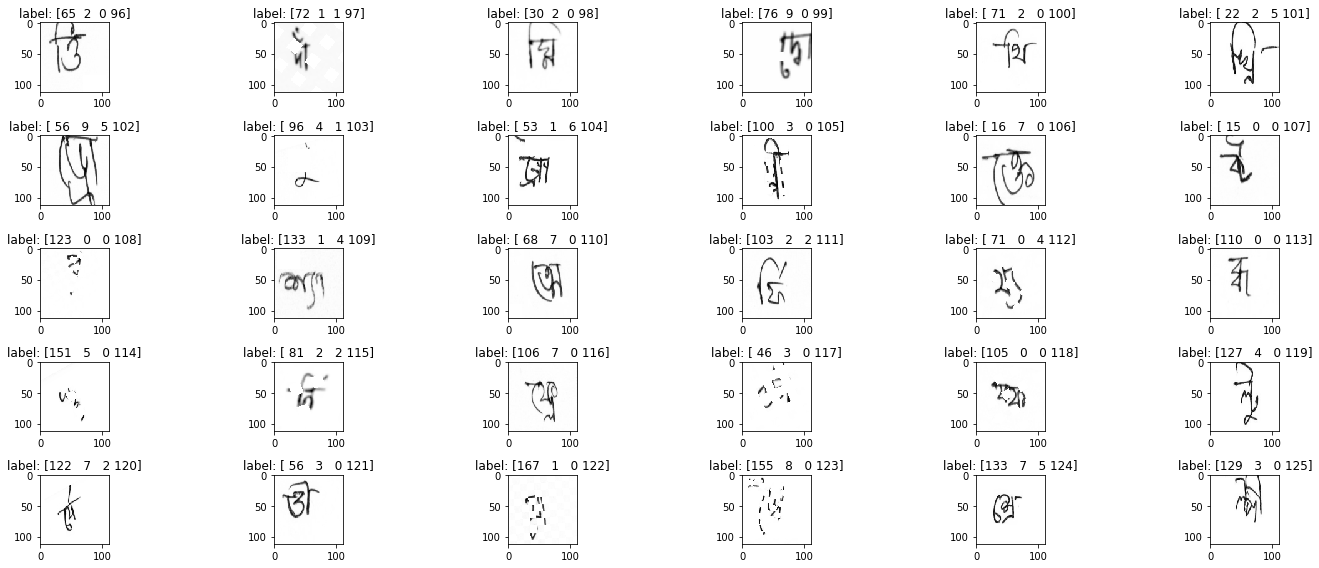

In [34]:
nrow, ncol = 5, 6

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    image, label = train_dataset[i+100]
    ax.imshow(image[0], cmap='Greys')
    ax.set_title(f'label: {label}')
plt.tight_layout()

In [35]:
# nrow, ncol = 5, 6

# fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
# axes = axes.flatten()
# for i, ax in tqdm(enumerate(axes)):
#     image, label = train_dataset_noaug[i+100]
#     ax.imshow(image, cmap='Greys')
#     ax.set_title(f'label: {label}')
# plt.tight_layout()

In [36]:
# %reload_ext autoreload
# %autoreload 2

# from PIL import Image, ImageEnhance, ImageOps
# import numpy as np
# import matplotlib.pyplot as plt
# import math
# import random
# import pdb
# from autoaugment import ImageNetPolicy, CIFAR10Policy, SVHNPolicy, SubPolicy

In [37]:
# import PIL
# print("Using Pillow version {}. Upgrade using 'pip install Pillow -U'".format(PIL.__version__))

In [38]:
# class AutoTransform:
#     def __init__(self, crop=True, size=(64, 64),
#                  normalize=True, train=True, threshold=TH,
#                  sigma=-1., blur_ratio=0., noise_ratio=0., cutout_ratio=0.,
#                  grid_distortion_ratio=0., elastic_distortion_ratio=0., 
#                  piece_affine_ratio=0., auto_aug=False):
#         self.crop = crop
#         self.size = size
#         self.normalize = normalize
#         self.train = train
#         self.threshold = threshold / 255.
#         self.sigma = sigma / 255.

#         self.blur_ratio = blur_ratio
#         self.noise_ratio = noise_ratio
#         self.cutout_ratio = cutout_ratio
#         self.grid_distortion_ratio = grid_distortion_ratio
#         self.elastic_distortion_ratio = elastic_distortion_ratio
#         self.piece_affine_ratio = piece_affine_ratio
#         self.auto_policy = SVHNPolicy()
#         self.auto_aug = auto_aug

#     def __call__(self, example):
#         if self.train:
#             x, y = example
#         else:
#             x = example
            
#         # --- Train/Test common preprocessing ---
#         if self.crop:
#             x = crop_char_image(x, threshold=self.threshold)
            
# #         if self.crop:
# #             x = crop_char_image_thin(x, threshold=self.threshold)

#         if self.size is not None:
#             x = resize(x, size=self.size)
            
#         x = np.transpose(np.stack((x, x, x), axis=0),(1,2,0))
        
#         if self.auto_aug:
#             x_int = Image.fromarray((x*255).astype(np.uint8))
#             x_int = self.auto_policy(x_int)
#             x = numpy.asarray(x_int).astype(np.float32) / 255.
        
#         if self.sigma > 0.:
#             x = add_gaussian_noise(x, sigma=self.sigma)

#         # albumentations...
#         x = x.astype(np.float32)
# #         assert x.ndim == 2
#         # 1. blur
#         if _evaluate_ratio(self.blur_ratio):
#             r = np.random.uniform()
#             if r < 0.25:
#                 x = apply_aug(A.Blur(p=1.0), x)
#             elif r < 0.5:
#                 x = apply_aug(A.MedianBlur(blur_limit=5, p=1.0), x)
#             elif r < 0.75:
#                 x = apply_aug(A.GaussianBlur(p=1.0), x)
#             else:
#                 x = apply_aug(A.MotionBlur(p=1.0), x)

#         if _evaluate_ratio(self.noise_ratio):
#             r = np.random.uniform()
#             if r < 0.50:
#                 x = apply_aug(A.GaussNoise(var_limit=5. / 255., p=1.0), x)
#             else:
#                 x = apply_aug(A.MultiplicativeNoise(p=1.0), x)

#         if _evaluate_ratio(self.cutout_ratio):
#             r = np.random.uniform()
#             if r < 0.5:
#                 x = apply_aug(A.CoarseDropout(max_holes=4, max_height=image_size//8, max_width=image_size//8, p=1.0), x)
#             else:
#                 x = apply_aug(A.Cutout(num_holes=1,  max_h_size=image_size//3, max_w_size=image_size//3, p=1.0),x)  # Deprecated...

#         if _evaluate_ratio(self.grid_distortion_ratio):
#             x = apply_aug(A.GridDistortion(p=1.0, border_mode=cv2.BORDER_CONSTANT, value=0), x)

#         if _evaluate_ratio(self.elastic_distortion_ratio):
#             x = apply_aug(A.ElasticTransform(
#                 sigma=50, alpha=1, alpha_affine=10, p=1.0, border_mode=cv2.BORDER_CONSTANT, value=0), x)


#         if _evaluate_ratio(self.piece_affine_ratio):
#             x = apply_aug(A.IAAPiecewiseAffine(p=1.0, mode='constant'), x)


#         if self.normalize:
# #             x = (x.astype(np.float32) - 0.0692) / 0.2051  ##ORG
#             x = (x.astype(np.float32) - 0.449) / 0.226 ##Imagenet
# #         if x.ndim == 2:
# #             x = x[None, :, :]
#         x = x.astype(np.float32)
#         x = np.transpose(x,(2,0,1))
#         if self.train:
#             y = y.astype(np.int64)
#             return x, y
#         else:
#             return x

In [39]:
# train_auto_transform = AutoTransform(auto_aug=True, crop=False,
#     size=(WIDTH_NEW, HEIGHT_NEW), cutout_ratio=0.5) #threshold=20.,
# train_auto_dataset = BengaliAIDataset(train_images[:200], train_labels,
#                                  transform=train_auto_transform)


In [40]:
# nrow, ncol = 5, 6

# fig, axes = plt.subpnrow, ncol = 5, 6

# fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
# axes = axes.flatten()
# for i, ax in tqdm(enumerate(axes)):
#     image, label = train_auto_dataset[i+100]
#     ax.imshow(np.transpose(image,(1,2,0)), cmap='Greys')
#     ax.set_title(f'label: {label}')
# plt.tight_layout()lots(nrow, ncol, figsize=(20, 8))
# axes = axes.flatten()
# for i, ax in tqdm(enumerate(axes)):
#     image, label = train_auto_dataset[i+100]
#     ax.imshow(np.transpose(image,(1,2,0)), cmap='Greys')
#     ax.set_title(f'label: {label}')
# plt.tight_layout()

<a id="model"></a> 
# pytorch model & define classifier

In [41]:
import torch


def residual_add(lhs, rhs):
    lhs_ch, rhs_ch = lhs.shape[1], rhs.shape[1]
    if lhs_ch < rhs_ch:
        out = lhs + rhs[:, :lhs_ch]
    elif lhs_ch > rhs_ch:
        out = torch.cat([lhs[:, :rhs_ch] + rhs, lhs[:, rhs_ch:]], dim=1)
    else:
        out = lhs + rhs
    return out


In [42]:
from typing import List

import torch
from torch import nn
from torch.nn.parameter import Parameter


class LazyLoadModule(nn.Module):
    """Lazy buffer/parameter loading using load_state_dict_pre_hook

    Define all buffer/parameter in `_lazy_buffer_keys`/`_lazy_parameter_keys` and
    save buffer with `register_buffer`/`register_parameter`
    method, which can be outside of __init__ method.
    Then this module can load any shape of Tensor during de-serializing.

    Note that default value of lazy buffer is torch.Tensor([]), while lazy parameter is None.
    """
    _lazy_buffer_keys: List[str] = []     # It needs to be override to register lazy buffer
    _lazy_parameter_keys: List[str] = []  # It needs to be override to register lazy parameter

    def __init__(self):
        super(LazyLoadModule, self).__init__()
        for k in self._lazy_buffer_keys:
            self.register_buffer(k, torch.tensor([]))
        for k in self._lazy_parameter_keys:
            self.register_parameter(k, None)
        self._register_load_state_dict_pre_hook(self._hook)

    def _hook(self, state_dict, prefix, local_metadata, strict, missing_keys,
             unexpected_keys, error_msgs):
        for key in self._lazy_buffer_keys:
            self.register_buffer(key, state_dict[prefix + key])

        for key in self._lazy_parameter_keys:
            self.register_parameter(key, Parameter(state_dict[prefix + key]))


In [43]:
a = np.array([2,3])
b = np.array([4,5,6])

In [44]:
import math
import torch
from torch.nn import init
from torch.nn.parameter import Parameter
import torch.nn.functional as F


class LazyLinear(LazyLoadModule):
    """Linear module with lazy input inference

    `in_features` can be `None`, and it is determined at the first time of forward step dynamically.
    """

    __constants__ = ['bias', 'in_features', 'out_features']
    _lazy_parameter_keys = ['weight']

    def __init__(self, in_features, out_features, bias=True):
        super(LazyLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        if bias:
            self.bias = Parameter(torch.Tensor(out_features))
        else:
            self.register_parameter('bias', None)

        if in_features is not None:
            self.weight = Parameter(torch.Tensor(out_features, in_features))
            self.reset_parameters()

    def reset_parameters(self):
        init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        if self.bias is not None:
            fan_in, _ = init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in)
            init.uniform_(self.bias, -bound, bound)

    def forward(self, input):
        if self.weight is None:
            self.in_features = input.shape[-1]
            self.weight = Parameter(torch.Tensor(self.out_features, self.in_features))
            self.reset_parameters()

            # Need to send lazy defined parameter to device...
            self.to(input.device)
        return F.linear(input, self.weight, self.bias)

    def extra_repr(self):
        return 'in_features={}, out_features={}, bias={}'.format(
            self.in_features, self.out_features, self.bias is not None
        )


In [45]:
from torch import nn
import torch.nn.functional as F


class LinearBlock(nn.Module):

    def __init__(self, in_features, out_features, bias=True,
                 use_bn=True, activation=F.relu, dropout_ratio=-1, residual=False,):
        super(LinearBlock, self).__init__()
        if in_features is None:
            self.linear = LazyLinear(in_features, out_features, bias=bias)
        else:
            self.linear = nn.Linear(in_features, out_features, bias=bias)
        if use_bn:
            self.bn = nn.BatchNorm1d(out_features)
        if dropout_ratio > 0.:
            self.dropout = nn.Dropout(p=dropout_ratio)
        else:
            self.dropout = None
        self.activation = activation
        self.use_bn = use_bn
        self.dropout_ratio = dropout_ratio
        self.residual = residual

    def __call__(self, x):
        h = self.linear(x)
        if self.use_bn:
            h = self.bn(h)
        if self.activation is not None:
            h = self.activation(h)
        if self.residual:
            h = residual_add(h, x)
        if self.dropout_ratio > 0:
            h = self.dropout(h)
        return h

In [46]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)
    
class Classifier(nn.Module):
    def __init__(self, inp = 2048, h1=1024, num_class = [1000,1,1,1], dropout_ratio=0.35):
        super().__init__()
        self.ap = nn.AdaptiveAvgPool2d(1)
        self.mp = nn.AdaptiveMaxPool2d(1)
        self.fla = Flatten()
#         self.bn0 = nn.BatchNorm1d(inp*2,eps=1e-05, momentum=0.1, affine=True)
        self.dropout0 = nn.Dropout(dropout_ratio)
        
        self.logit = nn.ModuleList(
            [ nn.Linear(inp, c) for c in num_class]
        )
#         self.fc1 = nn.Linear(inp*2, h1)
#         self.bn1 = nn.BatchNorm1d(h1,eps=1e-05, momentum=0.1, affine=True)
#         self.dropout1 = nn.Dropout(dropout_ratio)
#         self.fc2 = nn.Linear(h1, out)
        
    def forward(self, x):
#         ap = self.ap(x)
#         mp = self.mp(x)
#         x = torch.cat((ap,mp),dim=1)
        x = self.ap(x)
        x = self.fla(x)
#         x = self.bn0(x)
        x = self.dropout0(x)
        logit = [l(x) for l in self.logit]
#         x = F.relu(self.fc1(x))
#         x = self.bn1(x)
#         x = self.dropout1(x)         
#         x = self.fc2(x)
        return logit

In [47]:
# ap = nn.AdaptiveAvgPool2d((1,1))
# mp = nn.AdaptiveMaxPool2d((1,1))
# x = np.random.rand(5,4,4)
# print(x)
# print(ap)
# x1 = torch.nn.functional.adaptive_avg_pool2d(x, (1,1))
# print(x1)

In [48]:
a = torch.Tensor([[1,2],[3,4]])
b = torch.sum(a,dim=(-1,-2))
print(b)

tensor(10.)


In [49]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [50]:
import pretrainedmodels
import torch
from torch import nn
import torch.nn.functional as F
from torch.nn import Sequential
import collections
from dropblock import *

try:
    from collections import OrderedDict
except ImportError:
    OrderedDict = dict

from seresnext import *    

class PretrainedCNN(nn.Module):
    
    def load_pretrain(self, skip=['block0.','logit.'], is_print=True):
        load_pretrain(self, skip, pretrain_file=PRETRAIN_FILE, conversion=CONVERSION, is_print=is_print)
        
    def __init__(self, model_name='se_resnext101_32x4d',
                 in_channels=1, num_class=[10], use_bn=True,
                 pretrained='imagenet', dropout_ratio=0):
        super(PretrainedCNN, self).__init__()
#         self.conv0 = nn.Conv2d(
#             in_channels, 3, kernel_size=3, stride=1, padding=1, bias=True)
#         self.base_model = pretrainedmodels.__dict__[model_name](pretrained=pretrained)
# #         print(self.base_model)
#         names = []
#         for name, child in self.base_model.named_children():
#             names.append(name)
            
#         arch = self.base_model
#         arch = list(arch.children())
#         #saving the weights of the forst conv in w
#         w = arch[0][0].weight
#         #creating new Conv2d to accept 1 channel 
#         arch[0][0] = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
#         #substituting weights of newly created Conv2d with w from but we have to take mean
#         #to go from  3 channel to 1
#         arch[0][0].weight = nn.Parameter(torch.mean(w, dim=1, keepdim=True))
#         arch = nn.Sequential(OrderedDict([(names[k], arch[k]) for k in range(len(names))]))
# #         print(arch)
#         self.base_model = arch
# #         print("#######################################")
# #         print(self.base_model)
#         activation = F.leaky_relu
#         self.do_pooling = True
#         if self.do_pooling:
#             inch = self.base_model.last_linear.in_features
#         else:
#             inch = None

        e = ResNext50()

        self.block0 = e.block0
        self.block1 = e.block1
        self.block2 = e.block2
        self.block3 = e.block3
        self.block4 = e.block4
        e = None  #dropped
        inch = 2048
        hdim = HDIM
        self.dropblock0 = DropBlock2D(drop_prob=0.2, block_size = 24)
        self.dropblock1 = DropBlock2D(drop_prob=0.2, block_size = 12)
        self.dropblock2 = DropBlock2D(drop_prob=0.2, block_size = 6)
        
        self.classifer = Classifier(inp = inch, h1=hdim, num_class = num_class, dropout_ratio=dropout_ratio)
#         lin1 = LinearBlock(inch, hdim, use_bn=use_bn, activation=activation, residual=False)
#         lin2 = LinearBlock(hdim, out_dim, use_bn=use_bn, activation=None, residual=False)
#         self.lin_layers = Sequential(lin1, lin2)

    def forward(self, x):
        
#         h = self.base_model.layer0(x)
#         h = self.base_model.layer1(h)
#         h = self.base_model.layer2(h)
#         h = self.base_model.layer3(h)
#         h = self.base_model.layer4(h) 

        batch_size,C,H,W = x.shape
        if (H,W) !=(HEIGHT_NEW, WIDTH_NEW):
            x = F.interpolate(x,size=(HEIGHT_NEW, WIDTH_NEW), mode='bilinear',align_corners=False)
        x = x.expand(-1, 3, -1, -1)
        x = self.block0(x)
        x = self.dropblock0(x)
        x = self.block1(x)
        x = self.dropblock1(x)
        x = self.block2(x)
        x = self.dropblock2(x)
        x = self.block3(x)
        x = self.block4(x)
        
        h = self.classifer(x)

        return h

In [51]:
def print_base_layers(predictor):
    print("base model layer names::")
    for name, child in predictor.base_model.named_children():
        print(name)
        
def print_base_grad_status(predictor):
    print("base model grad status::")
    for name, child in predictor.base_model.named_children():
        print(name)
        for param in child.parameters():
            print(param.requires_grad)

In [52]:
# print_grad_status(predictortmp)

In [53]:
def frozen_basiclayers(predictor):
    for name, child in predictor.base_model.named_children():
        if name in ['layer0','layer1','layer2','layer3']:
            print(name + ' is frozen')
            for param in child.parameters():
                param.requires_grad = False
        else:
            print(name + ' is unfrozen')
            for param in child.parameters():
                param.requires_grad = True

In [54]:
def unfrozen_basiclayers(predictor):
    for name, child in predictor.base_model.named_children():
        for param in child.parameters():
            param.requires_grad = True

In [55]:
# frozen_basiclayers(predictortmp)
# print_grad_status(predictortmp)

In [56]:
n_grapheme = 168
n_vowel = 11
n_consonant = 7
n_total = n_grapheme + n_vowel + n_consonant
print('n_total', n_total)

n_total 186


In [57]:
# predictortmp = PretrainedCNN(in_channels=1, num_class=[n_grapheme, n_vowel, n_consonant], model_name=model_name, pretrained="imagenet")
# for name, child in predictortmp.named_children():
#     print(name)
# print_base_layers(predictortmp)

In [58]:
# def get_optimizer_adam(classifier, learning_rate=1e-3, weight_decay=0.0):
    
#     base_params = list(map(id, classifier.predictor.base_model.parameters()))
#     fast_learned_params = filter(lambda p: id(p) not in base_params, 
#                                  classifier.parameters())
# #     print("base_params len:", len(base_params))
# #     print("fast_learned_params len:", len(list(fast_learned_params)))
#     lr_100 = max(learning_rate/100, 1e-6)
#     lr_10 = max(learning_rate/10, 5e-6)
#     optimizer = torch.optim.Adam(
#     [
#         dict(params=classifier.predictor.base_model.layer0.parameters(), lr=lr_100),
#         dict(params=classifier.predictor.base_model.layer1.parameters(), lr=lr_100),
#         dict(params=classifier.predictor.base_model.layer2.parameters(), lr=lr_100),
#         dict(params=classifier.predictor.base_model.layer3.parameters(), lr=lr_100),
#         dict(params=classifier.predictor.base_model.layer4.parameters(), lr=lr_10),        
#         dict(params=classifier.predictor.base_model.avg_pool.parameters(), lr=lr_10),
#         dict(params=classifier.predictor.base_model.last_linear.parameters(), lr=lr_10),
#         {'params': fast_learned_params},
#     ], lr = learning_rate, weight_decay=weight_decay)
    
#     return optimizer

In [59]:
# def get_optimizer_adam(classifier, learning_rate=1e-3, weight_decay=0.0):
    
#     base_params = list(map(id, classifier.predictor.base_model.parameters()))
#     fast_learned_params = filter(lambda p: id(p) not in base_params, 
#                                  classifier.parameters())
# #     print("base_params len:", len(base_params))
# #     print("fast_learned_params len:", len(list(fast_learned_params)))
#     lr_100 = max(learning_rate/100, 1e-7)
#     lr_10 = max(learning_rate/10, 1e-7)
#     optimizer = torch.optim.Adam(
#     [
#         dict(params=classifier.predictor.base_model.layer0.parameters(), lr=lr_10),
#         dict(params=classifier.predictor.base_model.layer1.parameters(), lr=lr_10),
#         dict(params=classifier.predictor.base_model.layer2.parameters(), lr=lr_10),
#         dict(params=classifier.predictor.base_model.layer3.parameters(), lr=lr_10),
#         dict(params=classifier.predictor.base_model.layer4.parameters(), lr=learning_rate),        
#         dict(params=classifier.predictor.base_model.avg_pool.parameters(), lr=learning_rate),
#         dict(params=classifier.predictor.base_model.last_linear.parameters(), lr=learning_rate),
#         {'params': fast_learned_params},
#     ], lr = learning_rate, weight_decay=weight_decay)
    
#     return optimizer

In [60]:
def get_optimizer_adam(classifier, learning_rate=1e-3, weight_decay=0.0):
    
    base_params = list(map(id, classifier.predictor.parameters()))
    fast_learned_params = filter(lambda p: id(p) not in base_params, 
                                 classifier.parameters())
#     print("base_params len:", len(base_params))
#     print("fast_learned_params len:", len(list(fast_learned_params)))
    lr_100 = max(learning_rate/100, 1e-7)
    lr_10 = max(learning_rate/10, 1e-7)
    optimizer = torch.optim.Adam(
    [
        dict(params=classifier.predictor.block0.parameters(), lr=lr_10),
        dict(params=classifier.predictor.block1.parameters(), lr=lr_10),
        dict(params=classifier.predictor.block2.parameters(), lr=lr_10),
        dict(params=classifier.predictor.block3.parameters(), lr=lr_10),
        dict(params=classifier.predictor.block4.parameters(), lr=learning_rate),
        {'params': fast_learned_params},
    ], lr = learning_rate, weight_decay=weight_decay)
    
    return optimizer

## Classifier

In [61]:
import torch
from torch import nn
import torch.nn.functional as F
from tqdm import tqdm


def accuracy(y, t):
    pred_label = torch.argmax(y, dim=1)
    count = pred_label.shape[0]
    correct = (pred_label == t).sum().type(torch.float32)
    acc = correct / count
    if isinstance(acc, torch.Tensor):
        acc = acc.item()
    return acc


class BengaliClassifier(nn.Module):
    def __init__(self, predictor, n_grapheme=168, n_vowel=11, n_consonant=7):
        super(BengaliClassifier, self).__init__()
        self.n_grapheme = n_grapheme
        self.n_vowel = n_vowel
        self.n_consonant = n_consonant
        self.n_total_class = self.n_grapheme + self.n_vowel + self.n_consonant
        self.predictor = predictor

        self.metrics_keys = [
            'loss', 'loss_grapheme', 'loss_vowel', 'loss_consonant', 'loss_comb',
            'acc_grapheme', 'acc_vowel', 'acc_consonant', 'acc_comb']

    def forward(self, x, y=None):
        pred = self.predictor(x)
        if isinstance(pred, list):
            preds = pred
        else:
            assert pred.shape[1] == self.n_total_class
            preds = torch.split(pred, [self.n_grapheme, self.n_vowel, self.n_consonant], dim=1)
        loss_grapheme = 2*F.cross_entropy(preds[0], y[:, 0])
        loss_vowel = F.cross_entropy(preds[1], y[:, 1])
        loss_consonant = F.cross_entropy(preds[2], y[:, 2])
        loss_comb = 0.1*F.cross_entropy(preds[3], y[:, 3])
        loss = loss_grapheme + loss_vowel + loss_consonant + loss_comb
        metrics = {
            'loss': loss.item(),
            'loss_grapheme': loss_grapheme.item(),
            'loss_vowel': loss_vowel.item(),
            'loss_consonant': loss_consonant.item(),
            'loss_comb': loss_comb.item(),
            'acc_grapheme': accuracy(preds[0], y[:, 0]),
            'acc_vowel': accuracy(preds[1], y[:, 1]),
            'acc_consonant': accuracy(preds[2], y[:, 2]),
            'acc_comb': accuracy(preds[3], y[:, 3]),
        }
        return loss, metrics, pred

    def calc(self, data_loader):
        device: torch.device = next(self.parameters()).device
        self.eval()
        output_list = []
        with torch.no_grad():
            for batch in tqdm(data_loader):
                # TODO: support general preprocessing.
                # If `data` is not `Data` instance, `to` method is not supported!
                batch = batch.to(device)
                pred = self.predictor(batch)
                output_list.append(pred)
        output = torch.cat(output_list, dim=0)
        preds = torch.split(output, [self.n_grapheme, self.n_vowel, self.n_consonant], dim=1)
        return preds

    def predict_proba(self, data_loader):
        preds = self.calc(data_loader)
        return [F.softmax(p, dim=1) for p in preds]

    def predict(self, data_loader):
        preds = self.calc(data_loader)
        pred_labels = [torch.argmax(p, dim=1) for p in preds]
        return pred_labels


In [62]:
# classifiertmp = BengaliClassifier(predictortmp).to(device)
# # for name, child in classifiertmp.named_children():
# #     print(name)
# # optimizertmp = get_optimizer_adam(classifiertmp)
# # print(optimizertmp)

# ctmp_params = list(map(id, classifiertmp.parameters()))
# print(len(ctmp_params))

# pbtmp_params = list(map(id, predictortmp.base_model.parameters()))
# print(len(pbtmp_params))

# pcftmp_params = list(map(id, predictortmp.classifer.parameters()))
# print(len(pcftmp_params))

# opt_tmp = get_optimizer_adam(classifiertmp)
# print(opt_tmp)

<a id="train"></a>
# Training code


In [63]:
# --- Model ---
device = torch.device(device)

def schedule_lr(metrics):
    avg_mae = metrics['recall']
    # --- update lr ---
    lr = scheduler.optimizer.param_groups[-1]['lr']
    scheduler.step(avg_mae)
    log_report.report('lr', lr)

## prepare data

In [64]:
from logging import getLogger
import numpy
import os
from time import perf_counter
import argparse
from distutils.util import strtobool
import torch
from numpy.random.mtrand import RandomState
from torch.utils.data.dataloader import DataLoader

import pandas as pd
import torch
import json


def save_json(filepath, params):
    with open(filepath, 'w') as f:
        json.dump(params, f, indent=4)

class DictOutputTransform:
    def __init__(self, key, index=0):
        self.key = key
        self.index = index

    def __call__(self, x):
        if self.index >= 0:
            x = x[self.index]
        return x[self.key]


In [65]:
class LogReport:
    def __init__(self, dirpath=None, logger=None):
        self.dirpath = str(dirpath) if dirpath is not None else None
        self.logger = logger or getLogger(__name__)

        self.reported_dict = {}  # To handle additional parameter to monitor
        self.history = []
        self.start_time = perf_counter()

    def report(self, key, value):
        self.reported_dict[key] = value

    def __call__(self, epoch, iteration, train_metrics, val_metrics, mode):
        elapsed_time = perf_counter() - self.start_time
        elem = {'epoch': epoch,
                'iteration': iteration}
        
        elem.update({f'train/{key}': value
                     for key, value in train_metrics.items()})
        
        elem.update({f'val/{key}': value
             for key, value in val_metrics.items()})
        
        elem.update(self.reported_dict)
        elem['elapsed_time'] = elapsed_time
#         print("mode in log type:{}, val:{}".format(type(mode), mode))
        elem['mode'] = str(mode)
        self.history.append(elem)
        if self.dirpath:
            save_json(os.path.join(self.dirpath, 'log.json'), self.history)
            self.get_dataframe().to_csv(os.path.join(self.dirpath, 'log.csv'), index=False)

        # --- print ---
        msg = ''
        for key, value in elem.items():
            if key in ['iteration']:
                # skip printing some parameters...
                continue
            elif isinstance(value, int):
                msg += f'{key} {value: >6d} '
            elif isinstance(value, str):
                msg += f'{key} {value} '
            else:
                msg += f'{key} {value: 8f} '
#         self.logger.warning(msg)
        print(msg)

        # --- Reset ---
        self.reported_dict = {}

    def get_dataframe(self):
        df = pd.DataFrame(self.history)
        return df

In [66]:
class ModelSnapshotHandler:
    def __init__(self, model, filepath='model_{count:06}.pt',
                 interval=1, logger=None):
        self.model = model
        self.filepath: str = str(filepath)
        self.interval = interval
        self.logger = logger or getLogger(__name__)
        self.count = 0

    def __call__(self):
        self.count += 1
        filepath = self.filepath.format(count=self.count)
        torch.save(self.model.state_dict(), filepath)

In [67]:
import numpy as np
import sklearn.metrics
import torch


def macro_recall(pred_y, y, n_grapheme=168, n_vowel=11, n_consonant=7, n_comb_class = 1295):
    if not isinstance(pred_y, list):
        pred_y = torch.split(pred_y, [n_grapheme, n_vowel, n_consonant], dim=1)
    pred_labels = [torch.argmax(py, dim=1).cpu().numpy() for py in pred_y]

    y = y.cpu().numpy()
    # pred_y = [p.cpu().numpy() for p in pred_y]

    recall_grapheme = sklearn.metrics.recall_score(y[:, 0], pred_labels[0],average='macro')
    recall_vowel = sklearn.metrics.recall_score(y[:, 1], pred_labels[1], average='macro')
    recall_consonant = sklearn.metrics.recall_score(y[:, 2], pred_labels[2], average='macro')
    recall_comb = sklearn.metrics.recall_score(y[:, 3], pred_labels[3], average='macro')    
    scores = [recall_grapheme, recall_vowel, recall_consonant, recall_comb]
    final_score = np.average(scores, weights=[2, 1, 1, 0])
    # print(f'recall: grapheme {recall_grapheme}, vowel {recall_vowel}, consonant {recall_consonant}, '
    #       f'total {final_score}, y {y.shape}')
    return final_score


def calc_macro_recall(solution, submission):
    # solution df, submission df
    scores = []
    for component in ['grapheme_root', 'consonant_diacritic', 'vowel_diacritic']:
        y_true_subset = solution[solution[component] == component]['target'].values
        y_pred_subset = submission[submission[component] == component]['target'].values
        scores.append(sklearn.metrics.recall_score(
            y_true_subset, y_pred_subset, average='macro'))
    final_score = np.average(scores, weights=[2, 1, 1])
    return final_score

In [68]:
loss_recall_names =  ['loss', 'loss_grapheme', 'loss_vowel', 'loss_consonant','loss_comb',
            'acc_grapheme', 'acc_vowel', 'acc_consonant','acc_comb', 'recall']

In [69]:
def train_model(epoch, data_loader, log_report, n_train_call):
    classifier.train()
    metrics_total = dict(zip(loss_recall_names, np.zeros([len(loss_recall_names)], dtype='float32')))
    n_tag = 0
    for batch_idx, (img_batch, regr_batch) in enumerate(tqdm(data_loader)):
        n_sub = img_batch.shape[0]
        img_batch = img_batch.to(device)
        regr_batch = regr_batch.to(device)
        
        optimizer.zero_grad()
        loss, metrics, pred_y = classifier(img_batch, regr_batch)
        
        recall = macro_recall(pred_y, regr_batch)
        metrics_total["recall"] = (metrics_total["recall"]*n_tag+recall*n_sub)/(n_tag+n_sub)
        for key, val in metrics.items():
                metrics_total[key] = (metrics_total[key]*n_tag+val*n_sub)/(n_tag+n_sub)
                
        n_tag = n_tag + n_sub
        n_train_call[0] += n_sub
        
        loss.backward()
        optimizer.step()
        
    return metrics_total, n_train_call

In [70]:
def evaluate_model(epoch, data_loader, log_report):
    classifier.eval()
    n_tag = 0
    metrics_total = dict(zip(loss_recall_names, np.zeros([len(loss_recall_names)], dtype='float32')))
    with torch.no_grad():
        for batch_idx, (img_batch, regr_batch) in enumerate(tqdm(data_loader)):
            n_sub = img_batch.shape[0]
            img_batch = img_batch.to(device)
            regr_batch = regr_batch.to(device)

            _, metrics, pred_y = classifier(img_batch, regr_batch)
        
            recall = macro_recall(pred_y, regr_batch)
            metrics_total["recall"] = (metrics_total["recall"]*n_tag+recall*n_sub)/(n_tag+n_sub)
            for key, val in metrics.items():
                    metrics_total[key] = (metrics_total[key]*n_tag+val*n_sub)/(n_tag+n_sub)

            n_tag = n_tag + n_sub
        
        schedule_lr(metrics_total)   
        return metrics_total


## Train


In [71]:
def save_res(predictor, l1, epoch, val_metrics, min_val_loss, max_val_recall, outdir):
    mode = list("000")
    if((epoch+1)%10==0):
        model_file_name = os.path.join(outdir, 'predictor_{}_{}.pt'.format(l1,epoch))
        torch.save(predictor.state_dict(), model_file_name)
        mode[0] = "1"
    if(val_metrics['loss']<min_val_loss):
        min_val_loss = val_metrics['loss']
        if mode[0] is "0":
            model_file_name = os.path.join(outdir, 'predictor_min_loss.pt')
            torch.save(predictor.state_dict(), model_file_name)
        mode[1] = "1"
    if(val_metrics['recall']>max_val_recall):
        max_val_recall = val_metrics['recall']
        if mode[0] is not "1" and mode[1] is not "1":
            model_file_name = os.path.join(outdir, 'predictor_max_recall.pt')
            torch.save(predictor.state_dict(), model_file_name)
        mode[2] = "1"
    mode = ''.join(mode)
    return mode, min_val_loss, max_val_recall

In [72]:
def save_params(outdir, k, img_h, img_w, th, arch, batchsize):
    save_json(os.path.join(outdir, 'args_{}.json'.format(k)), 
              {'image_w': img_w,
               'image_h': img_h,
               'threshold': th, 
               'batch_size':batchsize,
               'arch': arch, 
               'model_name': model_name,
               'learning_rate': LR,
               'weight_decay': WD,
               'dropout_ratio': DP,
               'hidden_dim':HDIM
              }
             )

In [73]:
def save_checkpoint(epochID, model, optimizer, scheduler, accMax, lossMIN, checkpoint_path, launchTimestamp):
    torch.save({'epoch': epochID + 1, 'state_dict': model.state_dict(), 'max_recall': accMax, 'loss_min': lossMIN,
                            'optimizer': optimizer.state_dict(), 'scheduler':scheduler.state_dict()},
                           checkpoint_path + '/m-checkpoint.pth.tar')
#      launchTimestamp + '-' + str("%.4f" % lossMIN) +
    
def load_checkpoint(model, checkpoint_path, optimizer):
    if checkpoint_path != None:
        checkpoint_path += '/m-checkpoint.pth.tar'
        model_CKPT = torch.load(checkpoint_path)
        model.load_state_dict(model_CKPT['state_dict'])
        print('loading checkpoint!')
        optimizer.load_state_dict(model_CKPT['optimizer'])
        epoch = model_CKPT['epoch']
        acc_Max = model_CKPT['max_recall']
        loss_MIN = model_CKPT['loss_min']
        scheduler.load_state_dict(model_CKPT['scheduler'])
    return epoch, model, optimizer, scheduler, acc_Max, loss_MIN

In [74]:
import gc

# train_labels_total = train[['grapheme_root', 'vowel_diacritic', 'consonant_diacritic']].values
n_epochs = 150
kfold = 5
if not os.path.exists(outdir):
    os.mkdir(outdir)
for k in range(kfold):
    # Set pretrained='imagenet' to download imagenet pretrained model...
    predictor = PretrainedCNN(in_channels=1, num_class=[n_grapheme, n_vowel, n_consonant, n_comb_class], 
                              model_name=model_name, pretrained="imagenet", dropout_ratio=DP)
#     predictor.load_pretrain(is_print=False)
    predictor.load_state_dict(torch.load(trained_model_name))
    print('predictor', type(predictor))
    start_time = perf_counter()
    classifier = BengaliClassifier(predictor).to(device)
    # --- Training setting ---
    optimizer = torch.optim.Adam(classifier.parameters(), lr=LR, weight_decay=WD)
#     optimizer = get_optimizer_adam(classifier, learning_rate=LR, weight_decay=WD)

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='max', factor=0.7, patience=5, min_lr=1e-7)

    sub_dir = os.path.join(outdir,"{}_fold".format(k))
    if not os.path.exists(sub_dir):
        os.mkdir(sub_dir)
    log_report = LogReport(dirpath=sub_dir)
    n_train_call = [0]
    min_val_loss = 1e10
    max_val_recall = 0
    val_indexes = train[train['fold']==k].index.tolist()
#     train_indexes = train[train['fold']!=k].index.tolist()
    train_indexes = train.index.tolist()
    save_params(outdir, k, HEIGHT_NEW, WIDTH_NEW, TH, arch, batch_size)
    if debug:
        val_indexes = val_indexes[:100]
        train_indexes = train_indexes[:200]
#         print("val_indexes:", val_indexes[:5])
#     print("train_indexes:", len(np.unique(train_indexes)))
    train_dataset = BengaliAIDataset(
        train_images, train_labels, transform=train_transform,
        indices=train_indexes)
    valid_dataset = BengaliAIDataset(
        train_images, train_labels, transform=Transform(affine=False, crop=False, size=(WIDTH_NEW, HEIGHT_NEW)),
        indices=val_indexes)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
    
    for epoch in range(n_epochs):
        torch.cuda.empty_cache()
        gc.collect()
        train_metrics, n_train_call = train_model(epoch, train_loader, log_report, n_train_call)
        val_metrics = evaluate_model(epoch, valid_loader, log_report)
        mode, min_val_loss, max_val_recall = save_res(predictor, k, epoch, val_metrics, min_val_loss, 
                                                      max_val_recall, sub_dir)
        save_checkpoint(epoch, predictor, optimizer, scheduler, max_val_recall, min_val_loss, sub_dir, 
                                str(int(perf_counter()- start_time)))
#         print("mode type:{}, mode val:{}".format(type(mode), mode))
#         print("min_val_loss = ", min_val_loss)
#         print("max_val_recall = ", max_val_recall)
        log_report(epoch, n_train_call[0], train_metrics, val_metrics, mode)
    
    model_file_name = os.path.join(sub_dir, 'predictor_{}_{}.pt'.format(k,epoch))
    torch.save(predictor.state_dict(), model_file_name)

  0%|          | 0/4185 [00:00<?, ?it/s]

predictor <class '__main__.PretrainedCNN'>


/home/chen/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 in labels with no true samples.

  0%|          | 0/4185 [00:00<?, ?it/s]

epoch      0 train/loss  0.956593 train/loss_grapheme  0.672215 train/loss_vowel  0.116653 train/loss_consonant  0.099601 train/loss_comb  0.068124 train/acc_grapheme  0.911830 train/acc_vowel  0.963379 train/acc_consonant  0.967865 train/acc_comb  0.895121 train/recall  0.901074 val/loss  0.155013 val/loss_grapheme  0.095760 val/loss_vowel  0.023630 val/loss_consonant  0.022347 val/loss_comb  0.013276 val/acc_grapheme  0.986880 val/acc_vowel  0.994523 val/acc_consonant  0.993751 val/acc_comb  0.981876 val/recall  0.983196 lr  0.000050 elapsed_time  5028.515102 mode 011 


  0%|          | 0/4185 [00:00<?, ?it/s]

epoch      1 train/loss  0.827280 train/loss_grapheme  0.579111 train/loss_vowel  0.100444 train/loss_consonant  0.087051 train/loss_comb  0.060674 train/acc_grapheme  0.921440 train/acc_vowel  0.968029 train/acc_consonant  0.970942 train/acc_comb  0.906040 train/recall  0.911178 val/loss  0.132283 val/loss_grapheme  0.080258 val/loss_vowel  0.020687 val/loss_consonant  0.019146 val/loss_comb  0.012193 val/acc_grapheme  0.988324 val/acc_vowel  0.995046 val/acc_consonant  0.994448 val/acc_comb  0.983942 val/recall  0.985222 lr  0.000050 elapsed_time  10079.126690 mode 011 


  0%|          | 0/4185 [00:00<?, ?it/s]

epoch      2 train/loss  0.787062 train/loss_grapheme  0.549248 train/loss_vowel  0.094662 train/loss_consonant  0.084888 train/loss_comb  0.058264 train/acc_grapheme  0.925344 train/acc_vowel  0.969986 train/acc_consonant  0.972057 train/acc_comb  0.909729 train/recall  0.915067 val/loss  0.121675 val/loss_grapheme  0.072437 val/loss_vowel  0.019812 val/loss_consonant  0.016939 val/loss_comb  0.012488 val/acc_grapheme  0.989818 val/acc_vowel  0.995046 val/acc_consonant  0.995071 val/acc_comb  0.984341 val/recall  0.986860 lr  0.000050 elapsed_time  15125.614864 mode 011 


  0%|          | 0/4185 [00:00<?, ?it/s]

epoch      3 train/loss  0.764258 train/loss_grapheme  0.531728 train/loss_vowel  0.093216 train/loss_consonant  0.082527 train/loss_comb  0.056787 train/acc_grapheme  0.926832 train/acc_vowel  0.970638 train/acc_consonant  0.972376 train/acc_comb  0.910735 train/recall  0.917096 val/loss  0.104724 val/loss_grapheme  0.061795 val/loss_vowel  0.017024 val/loss_consonant  0.014652 val/loss_comb  0.011254 val/acc_grapheme  0.991162 val/acc_vowel  0.995419 val/acc_consonant  0.995594 val/acc_comb  0.985561 val/recall  0.988389 lr  0.000050 elapsed_time  20157.874181 mode 011 


  0%|          | 0/4185 [00:00<?, ?it/s]

epoch      4 train/loss  0.743936 train/loss_grapheme  0.516300 train/loss_vowel  0.090986 train/loss_consonant  0.081087 train/loss_comb  0.055563 train/acc_grapheme  0.928899 train/acc_vowel  0.971072 train/acc_consonant  0.972799 train/acc_comb  0.913897 train/recall  0.918603 val/loss  0.102093 val/loss_grapheme  0.060102 val/loss_vowel  0.016198 val/loss_consonant  0.013386 val/loss_comb  0.012406 val/acc_grapheme  0.991336 val/acc_vowel  0.995992 val/acc_consonant  0.995942 val/acc_comb  0.985361 val/recall  0.988611 lr  0.000050 elapsed_time  25189.653900 mode 011 


  0%|          | 0/4185 [00:00<?, ?it/s]

epoch      5 train/loss  0.724247 train/loss_grapheme  0.502083 train/loss_vowel  0.088263 train/loss_consonant  0.079264 train/loss_comb  0.054636 train/acc_grapheme  0.929889 train/acc_vowel  0.971863 train/acc_consonant  0.973511 train/acc_comb  0.914180 train/recall  0.920028 val/loss  0.095968 val/loss_grapheme  0.055055 val/loss_vowel  0.016075 val/loss_consonant  0.013467 val/loss_comb  0.011372 val/acc_grapheme  0.991984 val/acc_vowel  0.995693 val/acc_consonant  0.995768 val/acc_comb  0.986781 val/recall  0.988754 lr  0.000050 elapsed_time  30218.637517 mode 011 


  0%|          | 0/4185 [00:00<?, ?it/s]

epoch      6 train/loss  0.725691 train/loss_grapheme  0.504335 train/loss_vowel  0.088200 train/loss_consonant  0.078678 train/loss_comb  0.054479 train/acc_grapheme  0.930243 train/acc_vowel  0.971883 train/acc_consonant  0.973476 train/acc_comb  0.914868 train/recall  0.920172 val/loss  0.087752 val/loss_grapheme  0.049236 val/loss_vowel  0.015164 val/loss_consonant  0.011998 val/loss_comb  0.011354 val/acc_grapheme  0.992656 val/acc_vowel  0.995768 val/acc_consonant  0.996315 val/acc_comb  0.988125 val/recall  0.990017 lr  0.000050 elapsed_time  35246.611470 mode 011 


  0%|          | 0/4185 [00:00<?, ?it/s]

epoch      7 train/loss  0.717274 train/loss_grapheme  0.499302 train/loss_vowel  0.086804 train/loss_consonant  0.077051 train/loss_comb  0.054117 train/acc_grapheme  0.929949 train/acc_vowel  0.972491 train/acc_consonant  0.974323 train/acc_comb  0.915291 train/recall  0.920599 val/loss  0.121566 val/loss_grapheme  0.074736 val/loss_vowel  0.016425 val/loss_consonant  0.015360 val/loss_comb  0.015045 val/acc_grapheme  0.988374 val/acc_vowel  0.995519 val/acc_consonant  0.995494 val/acc_comb  0.983046 val/recall  0.985639 lr  0.000050 elapsed_time  40275.828327 mode 000 


  0%|          | 0/4185 [00:00<?, ?it/s]

epoch      8 train/loss  0.698379 train/loss_grapheme  0.484652 train/loss_vowel  0.085157 train/loss_consonant  0.075567 train/loss_comb  0.053003 train/acc_grapheme  0.932543 train/acc_vowel  0.972670 train/acc_consonant  0.974786 train/acc_comb  0.917850 train/recall  0.922913 val/loss  0.089685 val/loss_grapheme  0.051046 val/loss_vowel  0.014822 val/loss_consonant  0.011964 val/loss_comb  0.011852 val/acc_grapheme  0.992581 val/acc_vowel  0.996191 val/acc_consonant  0.996390 val/acc_comb  0.986606 val/recall  0.989954 lr  0.000050 elapsed_time  45305.308800 mode 000 


  0%|          | 0/4185 [00:00<?, ?it/s]

epoch      9 train/loss  0.694565 train/loss_grapheme  0.481766 train/loss_vowel  0.083461 train/loss_consonant  0.076481 train/loss_comb  0.052857 train/acc_grapheme  0.933156 train/acc_vowel  0.973128 train/acc_consonant  0.974716 train/acc_comb  0.918114 train/recall  0.923863 val/loss  0.077324 val/loss_grapheme  0.043346 val/loss_vowel  0.012221 val/loss_consonant  0.011036 val/loss_comb  0.010721 val/acc_grapheme  0.993652 val/acc_vowel  0.996739 val/acc_consonant  0.996515 val/acc_comb  0.988598 val/recall  0.991399 lr  0.000050 elapsed_time  50330.279552 mode 111 


  0%|          | 0/4185 [00:00<?, ?it/s]

epoch     10 train/loss  0.682083 train/loss_grapheme  0.471245 train/loss_vowel  0.084572 train/loss_consonant  0.073882 train/loss_comb  0.052385 train/acc_grapheme  0.933674 train/acc_vowel  0.972764 train/acc_consonant  0.974796 train/acc_comb  0.918687 train/recall  0.923589 val/loss  0.074544 val/loss_grapheme  0.041542 val/loss_vowel  0.011811 val/loss_consonant  0.010682 val/loss_comb  0.010510 val/acc_grapheme  0.994150 val/acc_vowel  0.996813 val/acc_consonant  0.996714 val/acc_comb  0.989195 val/recall  0.992083 lr  0.000050 elapsed_time  55366.124587 mode 011 


  0%|          | 0/4185 [00:00<?, ?it/s]

epoch     11 train/loss  0.671921 train/loss_grapheme  0.463765 train/loss_vowel  0.083069 train/loss_consonant  0.073445 train/loss_comb  0.051642 train/acc_grapheme  0.935322 train/acc_vowel  0.973750 train/acc_consonant  0.975538 train/acc_comb  0.919926 train/recall  0.925436 val/loss  0.072302 val/loss_grapheme  0.039655 val/loss_vowel  0.011830 val/loss_consonant  0.010147 val/loss_comb  0.010670 val/acc_grapheme  0.993950 val/acc_vowel  0.996664 val/acc_consonant  0.996813 val/acc_comb  0.989345 val/recall  0.991857 lr  0.000050 elapsed_time  60407.263745 mode 010 


  0%|          | 0/4185 [00:00<?, ?it/s]

epoch     12 train/loss  0.674474 train/loss_grapheme  0.464893 train/loss_vowel  0.083050 train/loss_consonant  0.074506 train/loss_comb  0.052024 train/acc_grapheme  0.935172 train/acc_vowel  0.973138 train/acc_consonant  0.974980 train/acc_comb  0.919618 train/recall  0.925117 val/loss  0.120536 val/loss_grapheme  0.074444 val/loss_vowel  0.016341 val/loss_consonant  0.014224 val/loss_comb  0.015527 val/acc_grapheme  0.988299 val/acc_vowel  0.995469 val/acc_consonant  0.995494 val/acc_comb  0.981777 val/recall  0.985485 lr  0.000050 elapsed_time  65449.097867 mode 000 


  0%|          | 0/4185 [00:00<?, ?it/s]

epoch     13 train/loss  0.659939 train/loss_grapheme  0.455757 train/loss_vowel  0.080726 train/loss_consonant  0.072207 train/loss_comb  0.051249 train/acc_grapheme  0.936024 train/acc_vowel  0.974233 train/acc_consonant  0.976225 train/acc_comb  0.921370 train/recall  0.926675 val/loss  0.071715 val/loss_grapheme  0.039710 val/loss_vowel  0.011483 val/loss_consonant  0.009658 val/loss_comb  0.010864 val/acc_grapheme  0.994224 val/acc_vowel  0.996938 val/acc_consonant  0.996913 val/acc_comb  0.988772 val/recall  0.992329 lr  0.000050 elapsed_time  70483.618474 mode 011 


  0%|          | 0/4185 [00:00<?, ?it/s]

epoch     14 train/loss  0.657829 train/loss_grapheme  0.453336 train/loss_vowel  0.080118 train/loss_consonant  0.073342 train/loss_comb  0.051033 train/acc_grapheme  0.936527 train/acc_vowel  0.974198 train/acc_consonant  0.975593 train/acc_comb  0.921639 train/recall  0.926784 val/loss  0.066382 val/loss_grapheme  0.037725 val/loss_vowel  0.010307 val/loss_consonant  0.007907 val/loss_comb  0.010444 val/acc_grapheme  0.994224 val/acc_vowel  0.997237 val/acc_consonant  0.997535 val/acc_comb  0.989892 val/recall  0.992673 lr  0.000050 elapsed_time  75531.826956 mode 011 


  0%|          | 0/4185 [00:00<?, ?it/s]

epoch     15 train/loss  0.654384 train/loss_grapheme  0.450901 train/loss_vowel  0.080259 train/loss_consonant  0.072303 train/loss_comb  0.050922 train/acc_grapheme  0.937059 train/acc_vowel  0.974403 train/acc_consonant  0.975822 train/acc_comb  0.921893 train/recall  0.927467 val/loss  0.064597 val/loss_grapheme  0.032857 val/loss_vowel  0.011285 val/loss_consonant  0.009656 val/loss_comb  0.010800 val/acc_grapheme  0.995270 val/acc_vowel  0.996739 val/acc_consonant  0.997112 val/acc_comb  0.990067 val/recall  0.993421 lr  0.000050 elapsed_time  80570.748567 mode 011 


  0%|          | 0/4185 [00:00<?, ?it/s]

epoch     16 train/loss  0.650509 train/loss_grapheme  0.447805 train/loss_vowel  0.080249 train/loss_consonant  0.071562 train/loss_comb  0.050892 train/acc_grapheme  0.936746 train/acc_vowel  0.973755 train/acc_consonant  0.976061 train/acc_comb  0.921435 train/recall  0.927505 val/loss  0.068684 val/loss_grapheme  0.036323 val/loss_vowel  0.010729 val/loss_consonant  0.009830 val/loss_comb  0.011802 val/acc_grapheme  0.994722 val/acc_vowel  0.997087 val/acc_consonant  0.996938 val/acc_comb  0.988847 val/recall  0.992713 lr  0.000050 elapsed_time  85610.269564 mode 000 


  0%|          | 0/4185 [00:00<?, ?it/s]

epoch     17 train/loss  0.639599 train/loss_grapheme  0.440844 train/loss_vowel  0.078067 train/loss_consonant  0.070453 train/loss_comb  0.050235 train/acc_grapheme  0.938224 train/acc_vowel  0.975050 train/acc_consonant  0.976404 train/acc_comb  0.922436 train/recall  0.928792 val/loss  0.059496 val/loss_grapheme  0.030568 val/loss_vowel  0.010624 val/loss_consonant  0.008082 val/loss_comb  0.010222 val/acc_grapheme  0.995693 val/acc_vowel  0.996988 val/acc_consonant  0.997386 val/acc_comb  0.990888 val/recall  0.993946 lr  0.000050 elapsed_time  90649.745270 mode 011 


  0%|          | 0/4185 [00:00<?, ?it/s]

epoch     18 train/loss  0.644018 train/loss_grapheme  0.442676 train/loss_vowel  0.079951 train/loss_consonant  0.070904 train/loss_comb  0.050487 train/acc_grapheme  0.937552 train/acc_vowel  0.974537 train/acc_consonant  0.976474 train/acc_comb  0.922237 train/recall  0.928392 val/loss  0.061112 val/loss_grapheme  0.033287 val/loss_vowel  0.009342 val/loss_consonant  0.008058 val/loss_comb  0.010426 val/acc_grapheme  0.994921 val/acc_vowel  0.997311 val/acc_consonant  0.997386 val/acc_comb  0.989892 val/recall  0.993085 lr  0.000050 elapsed_time  95687.736640 mode 000 


  0%|          | 0/4185 [00:00<?, ?it/s]

epoch     19 train/loss  0.634022 train/loss_grapheme  0.436944 train/loss_vowel  0.077478 train/loss_consonant  0.069687 train/loss_comb  0.049913 train/acc_grapheme  0.938145 train/acc_vowel  0.975005 train/acc_consonant  0.976708 train/acc_comb  0.923546 train/recall  0.929094 val/loss  0.058319 val/loss_grapheme  0.029712 val/loss_vowel  0.009625 val/loss_consonant  0.008553 val/loss_comb  0.010429 val/acc_grapheme  0.996216 val/acc_vowel  0.997237 val/acc_consonant  0.997262 val/acc_comb  0.990913 val/recall  0.994277 lr  0.000050 elapsed_time  100733.411153 mode 111 


  0%|          | 0/4185 [00:00<?, ?it/s]

epoch     20 train/loss  0.635807 train/loss_grapheme  0.436675 train/loss_vowel  0.077945 train/loss_consonant  0.071066 train/loss_comb  0.050121 train/acc_grapheme  0.938528 train/acc_vowel  0.974876 train/acc_consonant  0.976225 train/acc_comb  0.923681 train/recall  0.929009 val/loss  0.062223 val/loss_grapheme  0.033455 val/loss_vowel  0.009689 val/loss_consonant  0.008523 val/loss_comb  0.010557 val/acc_grapheme  0.995245 val/acc_vowel  0.997336 val/acc_consonant  0.997187 val/acc_comb  0.990440 val/recall  0.993326 lr  0.000050 elapsed_time  105769.534011 mode 000 


  0%|          | 0/4185 [00:00<?, ?it/s]

epoch     21 train/loss  0.625932 train/loss_grapheme  0.429717 train/loss_vowel  0.076224 train/loss_consonant  0.070387 train/loss_comb  0.049605 train/acc_grapheme  0.939419 train/acc_vowel  0.975637 train/acc_consonant  0.976439 train/acc_comb  0.924617 train/recall  0.930156 val/loss  0.058963 val/loss_grapheme  0.032018 val/loss_vowel  0.008735 val/loss_consonant  0.007819 val/loss_comb  0.010391 val/acc_grapheme  0.995270 val/acc_vowel  0.997610 val/acc_consonant  0.997610 val/acc_comb  0.990415 val/recall  0.993849 lr  0.000050 elapsed_time  110800.711728 mode 000 


  0%|          | 0/4185 [00:00<?, ?it/s]

epoch     22 train/loss  0.624161 train/loss_grapheme  0.427861 train/loss_vowel  0.077650 train/loss_consonant  0.069252 train/loss_comb  0.049398 train/acc_grapheme  0.939484 train/acc_vowel  0.974990 train/acc_consonant  0.976783 train/acc_comb  0.924816 train/recall  0.930232 val/loss  0.054180 val/loss_grapheme  0.027639 val/loss_vowel  0.008509 val/loss_consonant  0.007874 val/loss_comb  0.010158 val/acc_grapheme  0.996315 val/acc_vowel  0.997486 val/acc_consonant  0.997436 val/acc_comb  0.990913 val/recall  0.994525 lr  0.000050 elapsed_time  115846.416825 mode 011 


  0%|          | 0/4185 [00:00<?, ?it/s]

epoch     23 train/loss  0.616832 train/loss_grapheme  0.423292 train/loss_vowel  0.076157 train/loss_consonant  0.068293 train/loss_comb  0.049090 train/acc_grapheme  0.940540 train/acc_vowel  0.975642 train/acc_consonant  0.977370 train/acc_comb  0.925622 train/recall  0.931479 val/loss  0.054983 val/loss_grapheme  0.028929 val/loss_vowel  0.008716 val/loss_consonant  0.007230 val/loss_comb  0.010107 val/acc_grapheme  0.995743 val/acc_vowel  0.997336 val/acc_consonant  0.997585 val/acc_comb  0.990963 val/recall  0.994079 lr  0.000050 elapsed_time  120892.366992 mode 000 


  0%|          | 0/4185 [00:00<?, ?it/s]

epoch     24 train/loss  0.621071 train/loss_grapheme  0.426117 train/loss_vowel  0.077296 train/loss_consonant  0.068223 train/loss_comb  0.049435 train/acc_grapheme  0.940017 train/acc_vowel  0.975324 train/acc_consonant  0.977370 train/acc_comb  0.925294 train/recall  0.931162 val/loss  0.055212 val/loss_grapheme  0.028229 val/loss_vowel  0.009005 val/loss_consonant  0.007994 val/loss_comb  0.009984 val/acc_grapheme  0.995942 val/acc_vowel  0.997386 val/acc_consonant  0.997336 val/acc_comb  0.990913 val/recall  0.993987 lr  0.000050 elapsed_time  125932.297471 mode 000 


  0%|          | 0/4185 [00:00<?, ?it/s]

epoch     25 train/loss  0.621159 train/loss_grapheme  0.426094 train/loss_vowel  0.077463 train/loss_consonant  0.068353 train/loss_comb  0.049250 train/acc_grapheme  0.940022 train/acc_vowel  0.974816 train/acc_consonant  0.976922 train/acc_comb  0.925264 train/recall  0.930581 val/loss  0.063965 val/loss_grapheme  0.033832 val/loss_vowel  0.009408 val/loss_consonant  0.008769 val/loss_comb  0.011956 val/acc_grapheme  0.994448 val/acc_vowel  0.997286 val/acc_consonant  0.996938 val/acc_comb  0.989718 val/recall  0.992739 lr  0.000050 elapsed_time  130969.615615 mode 000 


  0%|          | 0/4185 [00:00<?, ?it/s]

epoch     26 train/loss  0.608827 train/loss_grapheme  0.418069 train/loss_vowel  0.075035 train/loss_consonant  0.067083 train/loss_comb  0.048640 train/acc_grapheme  0.940580 train/acc_vowel  0.975433 train/acc_consonant  0.977768 train/acc_comb  0.925921 train/recall  0.932174 val/loss  0.053861 val/loss_grapheme  0.029324 val/loss_vowel  0.007971 val/loss_consonant  0.006785 val/loss_comb  0.009780 val/acc_grapheme  0.995668 val/acc_vowel  0.997859 val/acc_consonant  0.997859 val/acc_comb  0.991087 val/recall  0.994706 lr  0.000050 elapsed_time  136007.964330 mode 011 


100%|██████████| 837/837 [05:10<00:00,  2.70it/s]


epoch     27 train/loss  0.606804 train/loss_grapheme  0.419179 train/loss_vowel  0.072921 train/loss_consonant  0.066046 train/loss_comb  0.048658 train/acc_grapheme  0.940336 train/acc_vowel  0.976822 train/acc_consonant  0.978112 train/acc_comb  0.926359 train/recall  0.931691 val/loss  0.051183 val/loss_grapheme  0.026638 val/loss_vowel  0.007394 val/loss_consonant  0.006545 val/loss_comb  0.010607 val/acc_grapheme  0.996241 val/acc_vowel  0.998158 val/acc_consonant  0.997983 val/acc_comb  0.990789 val/recall  0.994899 lr  0.000050 elapsed_time  141051.854919 mode 011 


  0%|          | 0/4185 [00:00<?, ?it/s]

epoch     28 train/loss  0.605724 train/loss_grapheme  0.416944 train/loss_vowel  0.073806 train/loss_consonant  0.066492 train/loss_comb  0.048481 train/acc_grapheme  0.941018 train/acc_vowel  0.976285 train/acc_consonant  0.978107 train/acc_comb  0.926768 train/recall  0.932586 val/loss  0.050551 val/loss_grapheme  0.026097 val/loss_vowel  0.007683 val/loss_consonant  0.006855 val/loss_comb  0.009916 val/acc_grapheme  0.995992 val/acc_vowel  0.997809 val/acc_consonant  0.997859 val/acc_comb  0.991336 val/recall  0.994765 lr  0.000050 elapsed_time  146089.423537 mode 010 


  0%|          | 0/4185 [00:00<?, ?it/s]

epoch     29 train/loss  0.606357 train/loss_grapheme  0.414254 train/loss_vowel  0.076000 train/loss_consonant  0.067469 train/loss_comb  0.048634 train/acc_grapheme  0.941336 train/acc_vowel  0.975841 train/acc_consonant  0.977400 train/acc_comb  0.926902 train/recall  0.932478 val/loss  0.052845 val/loss_grapheme  0.027865 val/loss_vowel  0.008016 val/loss_consonant  0.006683 val/loss_comb  0.010281 val/acc_grapheme  0.996042 val/acc_vowel  0.997834 val/acc_consonant  0.998033 val/acc_comb  0.990888 val/recall  0.994353 lr  0.000050 elapsed_time  151135.777479 mode 100 


  0%|          | 0/4185 [00:00<?, ?it/s]

epoch     30 train/loss  0.593058 train/loss_grapheme  0.405929 train/loss_vowel  0.073450 train/loss_consonant  0.065718 train/loss_comb  0.047962 train/acc_grapheme  0.942188 train/acc_vowel  0.976339 train/acc_consonant  0.977734 train/acc_comb  0.927465 train/recall  0.933447 val/loss  0.050496 val/loss_grapheme  0.026231 val/loss_vowel  0.007379 val/loss_consonant  0.007308 val/loss_comb  0.009579 val/acc_grapheme  0.995992 val/acc_vowel  0.997909 val/acc_consonant  0.997660 val/acc_comb  0.991112 val/recall  0.994459 lr  0.000050 elapsed_time  156188.426348 mode 010 


  0%|          | 0/4185 [00:00<?, ?it/s]

epoch     31 train/loss  0.598056 train/loss_grapheme  0.411831 train/loss_vowel  0.072510 train/loss_consonant  0.065560 train/loss_comb  0.048155 train/acc_grapheme  0.941974 train/acc_vowel  0.976783 train/acc_consonant  0.977992 train/acc_comb  0.927604 train/recall  0.933221 val/loss  0.058490 val/loss_grapheme  0.031089 val/loss_vowel  0.007928 val/loss_consonant  0.007294 val/loss_comb  0.012178 val/acc_grapheme  0.995120 val/acc_vowel  0.997311 val/acc_consonant  0.997660 val/acc_comb  0.989419 val/recall  0.993481 lr  0.000050 elapsed_time  161231.229495 mode 000 


  0%|          | 0/4185 [00:00<?, ?it/s]

epoch     32 train/loss  0.597718 train/loss_grapheme  0.409316 train/loss_vowel  0.074218 train/loss_consonant  0.066045 train/loss_comb  0.048139 train/acc_grapheme  0.942506 train/acc_vowel  0.976205 train/acc_consonant  0.978072 train/acc_comb  0.928047 train/recall  0.933801 val/loss  0.049397 val/loss_grapheme  0.025175 val/loss_vowel  0.007476 val/loss_consonant  0.006436 val/loss_comb  0.010310 val/acc_grapheme  0.996415 val/acc_vowel  0.997909 val/acc_consonant  0.997635 val/acc_comb  0.991336 val/recall  0.995006 lr  0.000050 elapsed_time  166273.613161 mode 011 


100%|██████████| 837/837 [05:12<00:00,  2.68it/s]


epoch     33 train/loss  0.595711 train/loss_grapheme  0.408983 train/loss_vowel  0.073112 train/loss_consonant  0.065535 train/loss_comb  0.048081 train/acc_grapheme  0.941675 train/acc_vowel  0.976075 train/acc_consonant  0.977634 train/acc_comb  0.926992 train/recall  0.932883 val/loss  0.042845 val/loss_grapheme  0.021418 val/loss_vowel  0.006492 val/loss_consonant  0.005414 val/loss_comb  0.009521 val/acc_grapheme  0.997037 val/acc_vowel  0.998232 val/acc_consonant  0.998432 val/acc_comb  0.992855 val/recall  0.996049 lr  0.000050 elapsed_time  171318.511351 mode 011 


  0%|          | 0/4185 [00:00<?, ?it/s]

epoch     34 train/loss  0.592365 train/loss_grapheme  0.403211 train/loss_vowel  0.074087 train/loss_consonant  0.067058 train/loss_comb  0.048009 train/acc_grapheme  0.943403 train/acc_vowel  0.975762 train/acc_consonant  0.977704 train/acc_comb  0.927898 train/recall  0.933953 val/loss  0.038625 val/loss_grapheme  0.017588 val/loss_vowel  0.006413 val/loss_consonant  0.005856 val/loss_comb  0.008767 val/acc_grapheme  0.997710 val/acc_vowel  0.998232 val/acc_consonant  0.998208 val/acc_comb  0.992880 val/recall  0.996476 lr  0.000050 elapsed_time  176358.536461 mode 011 


  0%|          | 0/4185 [00:00<?, ?it/s]

epoch     35 train/loss  0.582281 train/loss_grapheme  0.398396 train/loss_vowel  0.071447 train/loss_consonant  0.065040 train/loss_comb  0.047398 train/acc_grapheme  0.943288 train/acc_vowel  0.977007 train/acc_consonant  0.978515 train/acc_comb  0.928665 train/recall  0.934949 val/loss  0.046132 val/loss_grapheme  0.023448 val/loss_vowel  0.006162 val/loss_consonant  0.006239 val/loss_comb  0.010283 val/acc_grapheme  0.996689 val/acc_vowel  0.998183 val/acc_consonant  0.998307 val/acc_comb  0.992332 val/recall  0.995367 lr  0.000050 elapsed_time  181403.159617 mode 000 


  0%|          | 0/4185 [00:00<?, ?it/s]

epoch     36 train/loss  0.589696 train/loss_grapheme  0.404060 train/loss_vowel  0.072780 train/loss_consonant  0.065131 train/loss_comb  0.047724 train/acc_grapheme  0.942745 train/acc_vowel  0.976539 train/acc_consonant  0.978321 train/acc_comb  0.929227 train/recall  0.933498 val/loss  0.044026 val/loss_grapheme  0.021519 val/loss_vowel  0.006615 val/loss_consonant  0.006020 val/loss_comb  0.009872 val/acc_grapheme  0.997037 val/acc_vowel  0.998058 val/acc_consonant  0.998232 val/acc_comb  0.992108 val/recall  0.995803 lr  0.000050 elapsed_time  186463.197923 mode 000 


  0%|          | 0/4185 [00:00<?, ?it/s]

epoch     37 train/loss  0.590225 train/loss_grapheme  0.404186 train/loss_vowel  0.072693 train/loss_consonant  0.065573 train/loss_comb  0.047774 train/acc_grapheme  0.942955 train/acc_vowel  0.976653 train/acc_consonant  0.978162 train/acc_comb  0.928212 train/recall  0.934392 val/loss  0.035916 val/loss_grapheme  0.016642 val/loss_vowel  0.005583 val/loss_consonant  0.004865 val/loss_comb  0.008826 val/acc_grapheme  0.997909 val/acc_vowel  0.998382 val/acc_consonant  0.998681 val/acc_comb  0.993228 val/recall  0.996853 lr  0.000050 elapsed_time  191507.880874 mode 011 


  0%|          | 0/4185 [00:00<?, ?it/s]

epoch     38 train/loss  0.585904 train/loss_grapheme  0.400227 train/loss_vowel  0.071929 train/loss_consonant  0.066063 train/loss_comb  0.047685 train/acc_grapheme  0.943119 train/acc_vowel  0.976738 train/acc_consonant  0.977674 train/acc_comb  0.928436 train/recall  0.934276 val/loss  0.042152 val/loss_grapheme  0.020179 val/loss_vowel  0.006353 val/loss_consonant  0.005454 val/loss_comb  0.010166 val/acc_grapheme  0.997411 val/acc_vowel  0.998257 val/acc_consonant  0.998456 val/acc_comb  0.992805 val/recall  0.996380 lr  0.000050 elapsed_time  196557.185907 mode 000 


  0%|          | 0/4185 [00:00<?, ?it/s]

epoch     39 train/loss  0.583266 train/loss_grapheme  0.399100 train/loss_vowel  0.070896 train/loss_consonant  0.065716 train/loss_comb  0.047554 train/acc_grapheme  0.943423 train/acc_vowel  0.977290 train/acc_consonant  0.977624 train/acc_comb  0.928879 train/recall  0.935063 val/loss  0.039358 val/loss_grapheme  0.018824 val/loss_vowel  0.005867 val/loss_consonant  0.005600 val/loss_comb  0.009067 val/acc_grapheme  0.997361 val/acc_vowel  0.998307 val/acc_consonant  0.998282 val/acc_comb  0.992830 val/recall  0.995984 lr  0.000050 elapsed_time  201596.353884 mode 100 


  0%|          | 0/4185 [00:00<?, ?it/s]

epoch     40 train/loss  0.578599 train/loss_grapheme  0.396185 train/loss_vowel  0.071306 train/loss_consonant  0.064009 train/loss_comb  0.047100 train/acc_grapheme  0.943771 train/acc_vowel  0.977116 train/acc_consonant  0.978615 train/acc_comb  0.929387 train/recall  0.935226 val/loss  0.038124 val/loss_grapheme  0.017670 val/loss_vowel  0.005655 val/loss_consonant  0.005462 val/loss_comb  0.009337 val/acc_grapheme  0.997610 val/acc_vowel  0.998382 val/acc_consonant  0.998357 val/acc_comb  0.992979 val/recall  0.996378 lr  0.000050 elapsed_time  206637.364238 mode 000 


  0%|          | 0/4185 [00:00<?, ?it/s]

epoch     41 train/loss  0.572731 train/loss_grapheme  0.391653 train/loss_vowel  0.069681 train/loss_consonant  0.064475 train/loss_comb  0.046922 train/acc_grapheme  0.943731 train/acc_vowel  0.977544 train/acc_consonant  0.978580 train/acc_comb  0.929456 train/recall  0.935103 val/loss  0.047995 val/loss_grapheme  0.023586 val/loss_vowel  0.006963 val/loss_consonant  0.006610 val/loss_comb  0.010836 val/acc_grapheme  0.996813 val/acc_vowel  0.997959 val/acc_consonant  0.997983 val/acc_comb  0.991162 val/recall  0.995547 lr  0.000050 elapsed_time  211676.188501 mode 000 


  0%|          | 0/4185 [00:00<?, ?it/s]

epoch     42 train/loss  0.577143 train/loss_grapheme  0.396008 train/loss_vowel  0.070607 train/loss_consonant  0.063376 train/loss_comb  0.047152 train/acc_grapheme  0.944005 train/acc_vowel  0.977280 train/acc_consonant  0.978754 train/acc_comb  0.929113 train/recall  0.935379 val/loss  0.037496 val/loss_grapheme  0.016871 val/loss_vowel  0.006102 val/loss_consonant  0.005305 val/loss_comb  0.009216 val/acc_grapheme  0.997685 val/acc_vowel  0.998183 val/acc_consonant  0.998307 val/acc_comb  0.992731 val/recall  0.996640 lr  0.000050 elapsed_time  216717.527729 mode 000 


  0%|          | 0/4185 [00:00<?, ?it/s]

epoch     43 train/loss  0.570783 train/loss_grapheme  0.389805 train/loss_vowel  0.069959 train/loss_consonant  0.064378 train/loss_comb  0.046641 train/acc_grapheme  0.944558 train/acc_vowel  0.977763 train/acc_consonant  0.978560 train/acc_comb  0.930228 train/recall  0.936279 val/loss  0.037512 val/loss_grapheme  0.017992 val/loss_vowel  0.005753 val/loss_consonant  0.004755 val/loss_comb  0.009011 val/acc_grapheme  0.997486 val/acc_vowel  0.998382 val/acc_consonant  0.998805 val/acc_comb  0.993204 val/recall  0.996521 lr  0.000050 elapsed_time  221763.116192 mode 000 


  0%|          | 0/4185 [00:00<?, ?it/s]

epoch     44 train/loss  0.535770 train/loss_grapheme  0.364176 train/loss_vowel  0.067016 train/loss_consonant  0.060150 train/loss_comb  0.044428 train/acc_grapheme  0.948362 train/acc_vowel  0.978117 train/acc_consonant  0.979924 train/acc_comb  0.934420 train/recall  0.939691 val/loss  0.036792 val/loss_grapheme  0.017578 val/loss_vowel  0.005348 val/loss_consonant  0.004566 val/loss_comb  0.009299 val/acc_grapheme  0.997585 val/acc_vowel  0.998481 val/acc_consonant  0.998780 val/acc_comb  0.992307 val/recall  0.996338 lr  0.000035 elapsed_time  226802.055539 mode 000 


  0%|          | 0/4185 [00:00<?, ?it/s]

epoch     45 train/loss  0.529218 train/loss_grapheme  0.361425 train/loss_vowel  0.064007 train/loss_consonant  0.059507 train/loss_comb  0.044278 train/acc_grapheme  0.948740 train/acc_vowel  0.979317 train/acc_consonant  0.980104 train/acc_comb  0.934625 train/recall  0.940830 val/loss  0.034097 val/loss_grapheme  0.016051 val/loss_vowel  0.005357 val/loss_consonant  0.003814 val/loss_comb  0.008876 val/acc_grapheme  0.997784 val/acc_vowel  0.998407 val/acc_consonant  0.998780 val/acc_comb  0.993129 val/recall  0.996789 lr  0.000035 elapsed_time  231845.752187 mode 010 


100%|██████████| 837/837 [05:13<00:00,  2.67it/s]


epoch     46 train/loss  0.530170 train/loss_grapheme  0.361580 train/loss_vowel  0.065072 train/loss_consonant  0.059214 train/loss_comb  0.044304 train/acc_grapheme  0.948222 train/acc_vowel  0.978610 train/acc_consonant  0.979760 train/acc_comb  0.934625 train/recall  0.940100 val/loss  0.029639 val/loss_grapheme  0.013015 val/loss_vowel  0.004485 val/loss_consonant  0.003483 val/loss_comb  0.008656 val/acc_grapheme  0.998382 val/acc_vowel  0.998631 val/acc_consonant  0.999178 val/acc_comb  0.994399 val/recall  0.997770 lr  0.000035 elapsed_time  236884.301324 mode 011 


  0%|          | 0/4185 [00:00<?, ?it/s]

epoch     47 train/loss  0.513346 train/loss_grapheme  0.350078 train/loss_vowel  0.062208 train/loss_consonant  0.057652 train/loss_comb  0.043408 train/acc_grapheme  0.950274 train/acc_vowel  0.979456 train/acc_consonant  0.980626 train/acc_comb  0.936910 train/recall  0.942697 val/loss  0.027249 val/loss_grapheme  0.011572 val/loss_vowel  0.004393 val/loss_consonant  0.003157 val/loss_comb  0.008127 val/acc_grapheme  0.998730 val/acc_vowel  0.998830 val/acc_consonant  0.999079 val/acc_comb  0.994374 val/recall  0.997957 lr  0.000035 elapsed_time  241920.585045 mode 011 


  0%|          | 0/4185 [00:00<?, ?it/s]

epoch     48 train/loss  0.520228 train/loss_grapheme  0.355797 train/loss_vowel  0.062988 train/loss_consonant  0.057792 train/loss_comb  0.043651 train/acc_grapheme  0.948800 train/acc_vowel  0.979730 train/acc_consonant  0.980397 train/acc_comb  0.936293 train/recall  0.941350 val/loss  0.029897 val/loss_grapheme  0.013103 val/loss_vowel  0.004710 val/loss_consonant  0.003436 val/loss_comb  0.008648 val/acc_grapheme  0.998432 val/acc_vowel  0.998681 val/acc_consonant  0.999178 val/acc_comb  0.994274 val/recall  0.997702 lr  0.000035 elapsed_time  246960.647651 mode 000 


  0%|          | 0/4185 [00:00<?, ?it/s]

epoch     49 train/loss  0.521242 train/loss_grapheme  0.358035 train/loss_vowel  0.062124 train/loss_consonant  0.057329 train/loss_comb  0.043753 train/acc_grapheme  0.949004 train/acc_vowel  0.979675 train/acc_consonant  0.980631 train/acc_comb  0.935815 train/recall  0.940953 val/loss  0.028773 val/loss_grapheme  0.012308 val/loss_vowel  0.004502 val/loss_consonant  0.003138 val/loss_comb  0.008825 val/acc_grapheme  0.998531 val/acc_vowel  0.998805 val/acc_consonant  0.999129 val/acc_comb  0.994224 val/recall  0.997700 lr  0.000035 elapsed_time  252000.020773 mode 100 


  0%|          | 0/4185 [00:00<?, ?it/s]

epoch     50 train/loss  0.517681 train/loss_grapheme  0.352187 train/loss_vowel  0.063724 train/loss_consonant  0.058132 train/loss_comb  0.043638 train/acc_grapheme  0.949582 train/acc_vowel  0.979491 train/acc_consonant  0.980676 train/acc_comb  0.935974 train/recall  0.941512 val/loss  0.029542 val/loss_grapheme  0.013073 val/loss_vowel  0.004502 val/loss_consonant  0.003259 val/loss_comb  0.008708 val/acc_grapheme  0.998133 val/acc_vowel  0.998830 val/acc_consonant  0.999477 val/acc_comb  0.994399 val/recall  0.997612 lr  0.000035 elapsed_time  257043.993851 mode 000 


  0%|          | 0/4185 [00:00<?, ?it/s]

epoch     51 train/loss  0.507504 train/loss_grapheme  0.346046 train/loss_vowel  0.061907 train/loss_consonant  0.056404 train/loss_comb  0.043147 train/acc_grapheme  0.950299 train/acc_vowel  0.980243 train/acc_consonant  0.981015 train/acc_comb  0.936646 train/recall  0.942914 val/loss  0.032029 val/loss_grapheme  0.014623 val/loss_vowel  0.004689 val/loss_consonant  0.003393 val/loss_comb  0.009324 val/acc_grapheme  0.998208 val/acc_vowel  0.998705 val/acc_consonant  0.999203 val/acc_comb  0.993950 val/recall  0.997524 lr  0.000035 elapsed_time  262087.501990 mode 000 


  0%|          | 0/4185 [00:00<?, ?it/s]

epoch     52 train/loss  0.509352 train/loss_grapheme  0.347108 train/loss_vowel  0.062897 train/loss_consonant  0.056249 train/loss_comb  0.043098 train/acc_grapheme  0.950528 train/acc_vowel  0.979591 train/acc_consonant  0.980890 train/acc_comb  0.937224 train/recall  0.942711 val/loss  0.026046 val/loss_grapheme  0.011518 val/loss_vowel  0.003765 val/loss_consonant  0.002754 val/loss_comb  0.008009 val/acc_grapheme  0.998531 val/acc_vowel  0.999004 val/acc_consonant  0.999378 val/acc_comb  0.994548 val/recall  0.997783 lr  0.000035 elapsed_time  267126.340263 mode 010 


  0%|          | 0/4185 [00:00<?, ?it/s]

epoch     53 train/loss  0.514261 train/loss_grapheme  0.351194 train/loss_vowel  0.062254 train/loss_consonant  0.057484 train/loss_comb  0.043329 train/acc_grapheme  0.949920 train/acc_vowel  0.979621 train/acc_consonant  0.980726 train/acc_comb  0.936736 train/recall  0.942188 val/loss  0.027554 val/loss_grapheme  0.011901 val/loss_vowel  0.004103 val/loss_consonant  0.003055 val/loss_comb  0.008495 val/acc_grapheme  0.998656 val/acc_vowel  0.999004 val/acc_consonant  0.999303 val/acc_comb  0.994672 val/recall  0.997990 lr  0.000035 elapsed_time  272165.327368 mode 001 


  0%|          | 0/4185 [00:00<?, ?it/s]

epoch     54 train/loss  0.498129 train/loss_grapheme  0.339969 train/loss_vowel  0.061337 train/loss_consonant  0.054506 train/loss_comb  0.042318 train/acc_grapheme  0.951200 train/acc_vowel  0.980313 train/acc_consonant  0.981607 train/acc_comb  0.938115 train/recall  0.943459 val/loss  0.023802 val/loss_grapheme  0.009634 val/loss_vowel  0.003335 val/loss_consonant  0.002774 val/loss_comb  0.008059 val/acc_grapheme  0.999054 val/acc_vowel  0.999079 val/acc_consonant  0.999353 val/acc_comb  0.995096 val/recall  0.998355 lr  0.000024 elapsed_time  277203.056099 mode 011 


  0%|          | 0/4185 [00:00<?, ?it/s]

epoch     55 train/loss  0.479955 train/loss_grapheme  0.325511 train/loss_vowel  0.059824 train/loss_consonant  0.053382 train/loss_comb  0.041238 train/acc_grapheme  0.952674 train/acc_vowel  0.980407 train/acc_consonant  0.982274 train/acc_comb  0.939813 train/recall  0.945012 val/loss  0.024839 val/loss_grapheme  0.010772 val/loss_vowel  0.003547 val/loss_consonant  0.002571 val/loss_comb  0.007948 val/acc_grapheme  0.998755 val/acc_vowel  0.999004 val/acc_consonant  0.999427 val/acc_comb  0.995021 val/recall  0.998203 lr  0.000024 elapsed_time  282239.987265 mode 000 


  0%|          | 0/4185 [00:00<?, ?it/s]

epoch     56 train/loss  0.482493 train/loss_grapheme  0.328576 train/loss_vowel  0.059107 train/loss_consonant  0.053305 train/loss_comb  0.041506 train/acc_grapheme  0.953406 train/acc_vowel  0.980736 train/acc_consonant  0.982045 train/acc_comb  0.940435 train/recall  0.945954 val/loss  0.022750 val/loss_grapheme  0.008949 val/loss_vowel  0.003510 val/loss_consonant  0.002255 val/loss_comb  0.008036 val/acc_grapheme  0.999029 val/acc_vowel  0.999029 val/acc_consonant  0.999502 val/acc_comb  0.995345 val/recall  0.998649 lr  0.000024 elapsed_time  287283.454544 mode 011 


  0%|          | 0/4185 [00:00<?, ?it/s]

epoch     57 train/loss  0.476641 train/loss_grapheme  0.323135 train/loss_vowel  0.058944 train/loss_consonant  0.053277 train/loss_comb  0.041285 train/acc_grapheme  0.953993 train/acc_vowel  0.980726 train/acc_consonant  0.981816 train/acc_comb  0.940679 train/recall  0.945611 val/loss  0.023799 val/loss_grapheme  0.009880 val/loss_vowel  0.003215 val/loss_consonant  0.002771 val/loss_comb  0.007934 val/acc_grapheme  0.998880 val/acc_vowel  0.999203 val/acc_consonant  0.999353 val/acc_comb  0.994598 val/recall  0.998420 lr  0.000024 elapsed_time  292328.023375 mode 000 


  0%|          | 0/4185 [00:00<?, ?it/s]

epoch     58 train/loss  0.474441 train/loss_grapheme  0.323289 train/loss_vowel  0.057248 train/loss_consonant  0.052826 train/loss_comb  0.041077 train/acc_grapheme  0.953769 train/acc_vowel  0.981204 train/acc_consonant  0.982374 train/acc_comb  0.940789 train/recall  0.946614 val/loss  0.022563 val/loss_grapheme  0.009317 val/loss_vowel  0.003130 val/loss_consonant  0.002316 val/loss_comb  0.007801 val/acc_grapheme  0.998780 val/acc_vowel  0.999203 val/acc_consonant  0.999452 val/acc_comb  0.994996 val/recall  0.998258 lr  0.000024 elapsed_time  297369.233291 mode 010 


  0%|          | 0/4185 [00:00<?, ?it/s]

epoch     59 train/loss  0.466565 train/loss_grapheme  0.317437 train/loss_vowel  0.056801 train/loss_consonant  0.051811 train/loss_comb  0.040515 train/acc_grapheme  0.954606 train/acc_vowel  0.981582 train/acc_consonant  0.982449 train/acc_comb  0.941949 train/recall  0.947476 val/loss  0.019963 val/loss_grapheme  0.008029 val/loss_vowel  0.002654 val/loss_consonant  0.002088 val/loss_comb  0.007191 val/acc_grapheme  0.999079 val/acc_vowel  0.999353 val/acc_consonant  0.999527 val/acc_comb  0.995768 val/recall  0.998608 lr  0.000024 elapsed_time  302406.997853 mode 110 


  0%|          | 0/4185 [00:00<?, ?it/s]

epoch     60 train/loss  0.465402 train/loss_grapheme  0.317074 train/loss_vowel  0.056820 train/loss_consonant  0.050970 train/loss_comb  0.040539 train/acc_grapheme  0.954705 train/acc_vowel  0.981533 train/acc_consonant  0.982852 train/acc_comb  0.942004 train/recall  0.948011 val/loss  0.021764 val/loss_grapheme  0.008696 val/loss_vowel  0.002938 val/loss_consonant  0.002388 val/loss_comb  0.007742 val/acc_grapheme  0.998780 val/acc_vowel  0.999278 val/acc_consonant  0.999527 val/acc_comb  0.995120 val/recall  0.998188 lr  0.000024 elapsed_time  307450.051990 mode 000 


100%|██████████| 837/837 [05:11<00:00,  2.68it/s]


epoch     61 train/loss  0.469260 train/loss_grapheme  0.318707 train/loss_vowel  0.057467 train/loss_consonant  0.052452 train/loss_comb  0.040634 train/acc_grapheme  0.954207 train/acc_vowel  0.981099 train/acc_consonant  0.982339 train/acc_comb  0.942213 train/recall  0.946812 val/loss  0.023965 val/loss_grapheme  0.009513 val/loss_vowel  0.003350 val/loss_consonant  0.002799 val/loss_comb  0.008304 val/acc_grapheme  0.998979 val/acc_vowel  0.999104 val/acc_consonant  0.999328 val/acc_comb  0.995444 val/recall  0.998443 lr  0.000024 elapsed_time  312496.020553 mode 000 


  0%|          | 0/4185 [00:00<?, ?it/s]

epoch     62 train/loss  0.464387 train/loss_grapheme  0.315467 train/loss_vowel  0.057344 train/loss_consonant  0.051149 train/loss_comb  0.040426 train/acc_grapheme  0.954780 train/acc_vowel  0.981249 train/acc_consonant  0.982513 train/acc_comb  0.942193 train/recall  0.947403 val/loss  0.021819 val/loss_grapheme  0.008630 val/loss_vowel  0.003128 val/loss_consonant  0.002314 val/loss_comb  0.007747 val/acc_grapheme  0.999054 val/acc_vowel  0.999178 val/acc_consonant  0.999577 val/acc_comb  0.995519 val/recall  0.998658 lr  0.000024 elapsed_time  317540.758126 mode 001 


  0%|          | 0/4185 [00:00<?, ?it/s]

epoch     63 train/loss  0.444308 train/loss_grapheme  0.301882 train/loss_vowel  0.054115 train/loss_consonant  0.049076 train/loss_comb  0.039235 train/acc_grapheme  0.956617 train/acc_vowel  0.982419 train/acc_consonant  0.983360 train/acc_comb  0.943935 train/recall  0.949661 val/loss  0.018985 val/loss_grapheme  0.007067 val/loss_vowel  0.002624 val/loss_consonant  0.001899 val/loss_comb  0.007395 val/acc_grapheme  0.999452 val/acc_vowel  0.999228 val/acc_consonant  0.999751 val/acc_comb  0.995917 val/recall  0.999126 lr  0.000017 elapsed_time  322582.876346 mode 011 


  0%|          | 0/4185 [00:00<?, ?it/s]

epoch     64 train/loss  0.452984 train/loss_grapheme  0.307343 train/loss_vowel  0.055615 train/loss_consonant  0.050505 train/loss_comb  0.039521 train/acc_grapheme  0.956323 train/acc_vowel  0.981991 train/acc_consonant  0.982733 train/acc_comb  0.943204 train/recall  0.949293 val/loss  0.018280 val/loss_grapheme  0.006622 val/loss_vowel  0.002458 val/loss_consonant  0.001944 val/loss_comb  0.007256 val/acc_grapheme  0.999403 val/acc_vowel  0.999328 val/acc_consonant  0.999651 val/acc_comb  0.995818 val/recall  0.999001 lr  0.000017 elapsed_time  327636.877587 mode 010 


  0%|          | 0/4185 [00:00<?, ?it/s]

epoch     65 train/loss  0.441696 train/loss_grapheme  0.299528 train/loss_vowel  0.054367 train/loss_consonant  0.048816 train/loss_comb  0.038984 train/acc_grapheme  0.957708 train/acc_vowel  0.982698 train/acc_consonant  0.983011 train/acc_comb  0.944991 train/recall  0.950847 val/loss  0.019363 val/loss_grapheme  0.007279 val/loss_vowel  0.002494 val/loss_consonant  0.001990 val/loss_comb  0.007599 val/acc_grapheme  0.999303 val/acc_vowel  0.999278 val/acc_consonant  0.999577 val/acc_comb  0.995992 val/recall  0.998877 lr  0.000017 elapsed_time  332683.605760 mode 000 


  0%|          | 0/4185 [00:00<?, ?it/s]

epoch     66 train/loss  0.431146 train/loss_grapheme  0.290565 train/loss_vowel  0.054065 train/loss_consonant  0.047947 train/loss_comb  0.038569 train/acc_grapheme  0.958639 train/acc_vowel  0.982414 train/acc_consonant  0.983848 train/acc_comb  0.945768 train/recall  0.951219 val/loss  0.017161 val/loss_grapheme  0.005889 val/loss_vowel  0.002348 val/loss_consonant  0.001740 val/loss_comb  0.007183 val/acc_grapheme  0.999527 val/acc_vowel  0.999353 val/acc_consonant  0.999627 val/acc_comb  0.996340 val/recall  0.999142 lr  0.000017 elapsed_time  337727.477904 mode 011 


100%|██████████| 837/837 [05:12<00:00,  2.67it/s]


epoch     67 train/loss  0.439050 train/loss_grapheme  0.297915 train/loss_vowel  0.053410 train/loss_consonant  0.048793 train/loss_comb  0.038931 train/acc_grapheme  0.957324 train/acc_vowel  0.982907 train/acc_consonant  0.983559 train/acc_comb  0.944239 train/recall  0.950317 val/loss  0.020316 val/loss_grapheme  0.008044 val/loss_vowel  0.002624 val/loss_consonant  0.001806 val/loss_comb  0.007842 val/acc_grapheme  0.999104 val/acc_vowel  0.999278 val/acc_consonant  0.999651 val/acc_comb  0.995444 val/recall  0.998798 lr  0.000017 elapsed_time  342770.493147 mode 000 


  0%|          | 0/4185 [00:00<?, ?it/s]

epoch     68 train/loss  0.437847 train/loss_grapheme  0.296632 train/loss_vowel  0.052885 train/loss_consonant  0.049455 train/loss_comb  0.038874 train/acc_grapheme  0.957673 train/acc_vowel  0.982618 train/acc_consonant  0.983265 train/acc_comb  0.945479 train/recall  0.950793 val/loss  0.018953 val/loss_grapheme  0.007072 val/loss_vowel  0.002441 val/loss_consonant  0.001955 val/loss_comb  0.007486 val/acc_grapheme  0.999403 val/acc_vowel  0.999353 val/acc_consonant  0.999726 val/acc_comb  0.995768 val/recall  0.999189 lr  0.000017 elapsed_time  347809.933464 mode 001 


  0%|          | 0/4185 [00:00<?, ?it/s]

epoch     69 train/loss  0.434346 train/loss_grapheme  0.295829 train/loss_vowel  0.052405 train/loss_consonant  0.047393 train/loss_comb  0.038719 train/acc_grapheme  0.957762 train/acc_vowel  0.982857 train/acc_consonant  0.984321 train/acc_comb  0.945773 train/recall  0.951373 val/loss  0.018658 val/loss_grapheme  0.006900 val/loss_vowel  0.002310 val/loss_consonant  0.001839 val/loss_comb  0.007609 val/acc_grapheme  0.999403 val/acc_vowel  0.999452 val/acc_consonant  0.999602 val/acc_comb  0.995643 val/recall  0.999085 lr  0.000017 elapsed_time  352848.127863 mode 100 


  0%|          | 0/4185 [00:00<?, ?it/s]

epoch     70 train/loss  0.431195 train/loss_grapheme  0.291890 train/loss_vowel  0.052509 train/loss_consonant  0.048434 train/loss_comb  0.038362 train/acc_grapheme  0.958435 train/acc_vowel  0.982892 train/acc_consonant  0.983619 train/acc_comb  0.945623 train/recall  0.951053 val/loss  0.018049 val/loss_grapheme  0.006538 val/loss_vowel  0.002321 val/loss_consonant  0.001893 val/loss_comb  0.007296 val/acc_grapheme  0.999477 val/acc_vowel  0.999378 val/acc_consonant  0.999602 val/acc_comb  0.995643 val/recall  0.999139 lr  0.000012 elapsed_time  357893.755404 mode 000 


  0%|          | 0/4185 [00:00<?, ?it/s]

epoch     71 train/loss  0.421547 train/loss_grapheme  0.285392 train/loss_vowel  0.051291 train/loss_consonant  0.046960 train/loss_comb  0.037903 train/acc_grapheme  0.958992 train/acc_vowel  0.983265 train/acc_consonant  0.984067 train/acc_comb  0.946301 train/recall  0.952516 val/loss  0.020092 val/loss_grapheme  0.007744 val/loss_vowel  0.002481 val/loss_consonant  0.001977 val/loss_comb  0.007890 val/acc_grapheme  0.999079 val/acc_vowel  0.999353 val/acc_consonant  0.999527 val/acc_comb  0.995394 val/recall  0.998732 lr  0.000012 elapsed_time  362935.503806 mode 000 


  0%|          | 0/4185 [00:00<?, ?it/s]

epoch     72 train/loss  0.421502 train/loss_grapheme  0.285244 train/loss_vowel  0.051260 train/loss_consonant  0.047128 train/loss_comb  0.037869 train/acc_grapheme  0.959157 train/acc_vowel  0.983524 train/acc_consonant  0.984216 train/acc_comb  0.946679 train/recall  0.952562 val/loss  0.016633 val/loss_grapheme  0.005700 val/loss_vowel  0.002124 val/loss_consonant  0.001706 val/loss_comb  0.007103 val/acc_grapheme  0.999452 val/acc_vowel  0.999502 val/acc_consonant  0.999701 val/acc_comb  0.996440 val/recall  0.999136 lr  0.000012 elapsed_time  367982.262414 mode 010 


  0%|          | 0/4185 [00:00<?, ?it/s]

epoch     73 train/loss  0.418973 train/loss_grapheme  0.283171 train/loss_vowel  0.050723 train/loss_consonant  0.047419 train/loss_comb  0.037660 train/acc_grapheme  0.959321 train/acc_vowel  0.983499 train/acc_consonant  0.983818 train/acc_comb  0.947202 train/recall  0.952628 val/loss  0.015820 val/loss_grapheme  0.005405 val/loss_vowel  0.001956 val/loss_consonant  0.001431 val/loss_comb  0.007028 val/acc_grapheme  0.999477 val/acc_vowel  0.999502 val/acc_consonant  0.999826 val/acc_comb  0.996390 val/recall  0.999292 lr  0.000012 elapsed_time  373022.353547 mode 011 


  0%|          | 0/4185 [00:00<?, ?it/s]

epoch     74 train/loss  0.409396 train/loss_grapheme  0.276901 train/loss_vowel  0.049386 train/loss_consonant  0.045850 train/loss_comb  0.037259 train/acc_grapheme  0.960451 train/acc_vowel  0.983997 train/acc_consonant  0.984520 train/acc_comb  0.948232 train/recall  0.953834 val/loss  0.015729 val/loss_grapheme  0.005487 val/loss_vowel  0.002074 val/loss_consonant  0.001465 val/loss_comb  0.006703 val/acc_grapheme  0.999427 val/acc_vowel  0.999403 val/acc_consonant  0.999726 val/acc_comb  0.996390 val/recall  0.998996 lr  0.000012 elapsed_time  378066.374270 mode 010 


  0%|          | 0/4185 [00:00<?, ?it/s]

epoch     75 train/loss  0.411798 train/loss_grapheme  0.277952 train/loss_vowel  0.050577 train/loss_consonant  0.045929 train/loss_comb  0.037340 train/acc_grapheme  0.960237 train/acc_vowel  0.983599 train/acc_consonant  0.984674 train/acc_comb  0.947809 train/recall  0.953357 val/loss  0.016510 val/loss_grapheme  0.005748 val/loss_vowel  0.002101 val/loss_consonant  0.001620 val/loss_comb  0.007041 val/acc_grapheme  0.999378 val/acc_vowel  0.999378 val/acc_consonant  0.999676 val/acc_comb  0.996067 val/recall  0.999020 lr  0.000012 elapsed_time  383109.433356 mode 000 


  0%|          | 0/4185 [00:00<?, ?it/s]

epoch     76 train/loss  0.419301 train/loss_grapheme  0.285338 train/loss_vowel  0.050767 train/loss_consonant  0.045534 train/loss_comb  0.037662 train/acc_grapheme  0.959127 train/acc_vowel  0.983315 train/acc_consonant  0.984455 train/acc_comb  0.947028 train/recall  0.952483 val/loss  0.016610 val/loss_grapheme  0.006155 val/loss_vowel  0.002059 val/loss_consonant  0.001507 val/loss_comb  0.006889 val/acc_grapheme  0.999452 val/acc_vowel  0.999328 val/acc_consonant  0.999751 val/acc_comb  0.996166 val/recall  0.999130 lr  0.000012 elapsed_time  388145.396531 mode 000 


  0%|          | 0/4185 [00:00<?, ?it/s]

epoch     77 train/loss  0.414413 train/loss_grapheme  0.282168 train/loss_vowel  0.049475 train/loss_consonant  0.045448 train/loss_comb  0.037323 train/acc_grapheme  0.960048 train/acc_vowel  0.983664 train/acc_consonant  0.984829 train/acc_comb  0.948307 train/recall  0.953570 val/loss  0.015111 val/loss_grapheme  0.005100 val/loss_vowel  0.001847 val/loss_consonant  0.001305 val/loss_comb  0.006859 val/acc_grapheme  0.999527 val/acc_vowel  0.999502 val/acc_consonant  0.999801 val/acc_comb  0.996515 val/recall  0.999277 lr  0.000012 elapsed_time  393184.117198 mode 010 


  0%|          | 0/4185 [00:00<?, ?it/s]

epoch     78 train/loss  0.409945 train/loss_grapheme  0.276798 train/loss_vowel  0.050389 train/loss_consonant  0.045511 train/loss_comb  0.037247 train/acc_grapheme  0.960566 train/acc_vowel  0.983624 train/acc_consonant  0.984515 train/acc_comb  0.948372 train/recall  0.953669 val/loss  0.015006 val/loss_grapheme  0.004902 val/loss_vowel  0.001999 val/loss_consonant  0.001339 val/loss_comb  0.006766 val/acc_grapheme  0.999577 val/acc_vowel  0.999477 val/acc_consonant  0.999851 val/acc_comb  0.996689 val/recall  0.999344 lr  0.000012 elapsed_time  398232.615607 mode 011 


  0%|          | 0/4185 [00:00<?, ?it/s]

epoch     79 train/loss  0.412108 train/loss_grapheme  0.278539 train/loss_vowel  0.050485 train/loss_consonant  0.045898 train/loss_comb  0.037186 train/acc_grapheme  0.959844 train/acc_vowel  0.983225 train/acc_consonant  0.984445 train/acc_comb  0.947486 train/recall  0.953074 val/loss  0.014513 val/loss_grapheme  0.004819 val/loss_vowel  0.001813 val/loss_consonant  0.001414 val/loss_comb  0.006468 val/acc_grapheme  0.999602 val/acc_vowel  0.999502 val/acc_consonant  0.999876 val/acc_comb  0.996589 val/recall  0.999462 lr  0.000012 elapsed_time  403274.541400 mode 111 


  0%|          | 0/4185 [00:00<?, ?it/s]

epoch     80 train/loss  0.416195 train/loss_grapheme  0.281493 train/loss_vowel  0.051231 train/loss_consonant  0.046097 train/loss_comb  0.037374 train/acc_grapheme  0.960023 train/acc_vowel  0.983061 train/acc_consonant  0.984575 train/acc_comb  0.948093 train/recall  0.953120 val/loss  0.013340 val/loss_grapheme  0.004216 val/loss_vowel  0.001699 val/loss_consonant  0.001256 val/loss_comb  0.006169 val/acc_grapheme  0.999527 val/acc_vowel  0.999602 val/acc_consonant  0.999925 val/acc_comb  0.996838 val/recall  0.999392 lr  0.000012 elapsed_time  408310.886898 mode 010 


  0%|          | 0/4185 [00:00<?, ?it/s]

epoch     81 train/loss  0.406526 train/loss_grapheme  0.274272 train/loss_vowel  0.049986 train/loss_consonant  0.045200 train/loss_comb  0.037067 train/acc_grapheme  0.960172 train/acc_vowel  0.984102 train/acc_consonant  0.984649 train/acc_comb  0.948601 train/recall  0.953589 val/loss  0.018327 val/loss_grapheme  0.006606 val/loss_vowel  0.002137 val/loss_consonant  0.001837 val/loss_comb  0.007746 val/acc_grapheme  0.999328 val/acc_vowel  0.999502 val/acc_consonant  0.999602 val/acc_comb  0.995693 val/recall  0.998970 lr  0.000012 elapsed_time  413348.539154 mode 000 


  0%|          | 0/4185 [00:00<?, ?it/s]

epoch     82 train/loss  0.407435 train/loss_grapheme  0.275252 train/loss_vowel  0.049626 train/loss_consonant  0.045687 train/loss_comb  0.036869 train/acc_grapheme  0.960665 train/acc_vowel  0.983838 train/acc_consonant  0.984704 train/acc_comb  0.948765 train/recall  0.954158 val/loss  0.015707 val/loss_grapheme  0.005349 val/loss_vowel  0.001850 val/loss_consonant  0.001514 val/loss_comb  0.006994 val/acc_grapheme  0.999502 val/acc_vowel  0.999577 val/acc_consonant  0.999726 val/acc_comb  0.996291 val/recall  0.999281 lr  0.000012 elapsed_time  418383.946436 mode 000 


  0%|          | 0/4185 [00:00<?, ?it/s]

epoch     83 train/loss  0.407816 train/loss_grapheme  0.275226 train/loss_vowel  0.049934 train/loss_consonant  0.045602 train/loss_comb  0.037055 train/acc_grapheme  0.960750 train/acc_vowel  0.983708 train/acc_consonant  0.984759 train/acc_comb  0.949303 train/recall  0.953923 val/loss  0.016918 val/loss_grapheme  0.006020 val/loss_vowel  0.001979 val/loss_consonant  0.001637 val/loss_comb  0.007283 val/acc_grapheme  0.999353 val/acc_vowel  0.999502 val/acc_consonant  0.999801 val/acc_comb  0.996166 val/recall  0.999089 lr  0.000012 elapsed_time  423424.438424 mode 000 


  0%|          | 0/4185 [00:00<?, ?it/s]

epoch     84 train/loss  0.408946 train/loss_grapheme  0.277208 train/loss_vowel  0.049987 train/loss_consonant  0.044777 train/loss_comb  0.036975 train/acc_grapheme  0.960610 train/acc_vowel  0.983748 train/acc_consonant  0.985028 train/acc_comb  0.948302 train/recall  0.954023 val/loss  0.014407 val/loss_grapheme  0.004472 val/loss_vowel  0.001835 val/loss_consonant  0.001390 val/loss_comb  0.006711 val/acc_grapheme  0.999627 val/acc_vowel  0.999577 val/acc_consonant  0.999801 val/acc_comb  0.996689 val/recall  0.999403 lr  0.000012 elapsed_time  428472.546879 mode 000 


  3%|▎         | 119/4185 [02:15<1:16:58,  1.14s/it]Traceback (most recent call last):
  File "/home/chen/anaconda3/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/home/chen/anaconda3/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/chen/anaconda3/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/home/chen/anaconda3/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/home/chen/anaconda3/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/home/chen/anaconda3/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
Traceback (most recent call last):
  File "/home/chen/anaconda3/lib/pyth

KeyboardInterrupt: 

In [ ]:
# print(sub_dir)
# checkpoint_path = sub_dir
# model =  PretrainedCNN(in_channels=1, out_dim=n_total, model_name=model_name, pretrained=None)
# epoch, model, optimizer, scheduler, acc_Max, loss_MIN = load_checkpoint(model, checkpoint_path, optimizer)

In [ ]:
a = torch.Tensor([0.5])
print(a)
if isinstance(a, torch.Tensor):
    print(a.item())

In [ ]:
train_history = log_report.get_dataframe()
train_history.to_csv(outdir / 'log.csv', index=False)

train_history

<a id="pred"></a>
# Prediction

Please refer **[Bengali: SEResNeXt prediction with pytorch](https://www.kaggle.com/corochann/bengali-seresnext-prediction-with-pytorch)** for the prediction with trained model and submission for this competition!!!

<a id="ref"></a>
# Reference and further reading

#### Kernel

**[Bangali.AI super fast data loading with feather](https://www.kaggle.com/corochann/bangali-ai-super-fast-data-loading-with-feather)**<br>
Simple example of how use feather format data to load data faster.

**[Bengali: albumentations data augmentation tutorial](https://www.kaggle.com/corochann/bengali-albumentations-data-augmentation-tutorial)**<br>
Tutorial for Data augmentations with albumentations library.

**[Bengali: SEResNeXt prediction with pytorch](https://www.kaggle.com/corochann/bengali-seresnext-prediction-with-pytorch)**<br>
**Prediction code of this kernel's trained model, please check this too!**

**[Deep learning - CNN with Chainer: LB 0.99700](https://www.kaggle.com/corochann/deep-learning-cnn-with-chainer-lb-0-99700)**<br>
Data augmentation idea is based on this kernel, which achieves quite high accuracy on MNIST task.

#### Dataset
**[bengaliai-cv19-feather](https://www.kaggle.com/corochann/bengaliaicv19feather)**<br>
Feather format dataset

**[bengaliaicv19_seresnext101_32x4d](https://www.kaggle.com/corochann/bengaliaicv19-seresnext101-32x4d)**<br>
**Trained model weight with this kernel(v1)**

**[bengaliaicv19_trainedmodels](https://www.kaggle.com/corochann/bengaliaicv19-trainedmodels)**<br>
**Trained model weight with this kernel(v2~)**

#### Library
**https://github.com/pytorch/ignite**

Used for training code abstraction. The advantage of abstracting the code is that we can re-use implemented handler class for other training, other competition.<br>
You don't need to write code for saving models, logging training loss/metric, show progressbar etc.

**https://github.com/Cadene/pretrained-models.pytorch**

Many pretrained models are supported by this library, and we can switch to use them easily.
Other model may perform better in this competition.

**https://github.com/albumentations-team/albumentations**

fast image augmentation library and easy to use wrapper around other libraries https://arxiv.org/abs/1809.06839<br>
I could not show all the methods, you can find more methods in the library, check yourself!

<h3 style="color:red">If this kernel helps you, please upvote to keep me motivated :)<br>Thanks!</h3>

In [ ]:
print(optimizer)

In [75]:
model_file_name = os.path.join(outdir, 'predictor_{}_{}.pt'.format(0,epoch))
torch.save(predictor.state_dict(), model_file_name)

In [76]:
print(model_file_name)

../res/ResNext50_LR5e-05_WD0.0001_DP0.2_IM112-112_bs48_4head_c3aug-ftall/predictor_0_85.pt
